Using GPU : Quadro RTX 8000 (ID 0)


/state/partition1/job-64527132/ipykernel_2912764/461520935.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
/stat

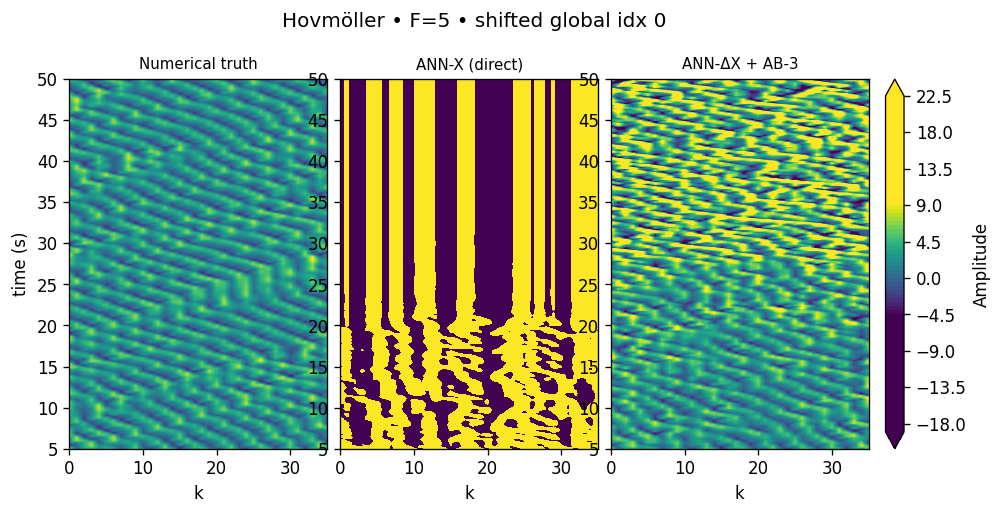

/state/partition1/job-64527132/ipykernel_2912764/461520935.py:255: RuntimeWarning: overflow encountered in square
  def rmse_t(pred, truth): return np.sqrt(((pred - truth)**2).mean(axis=1))
/scratch/jc11305/myenv/lib/python3.11/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


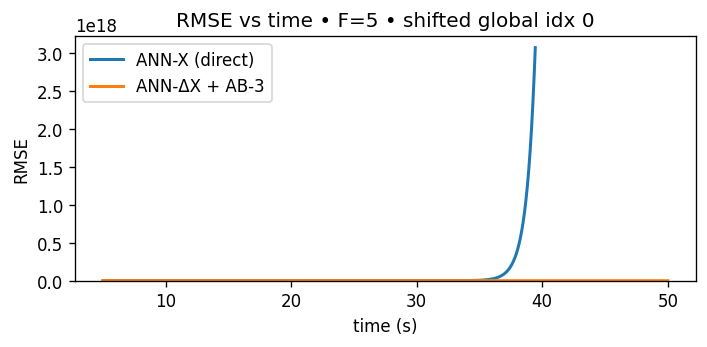

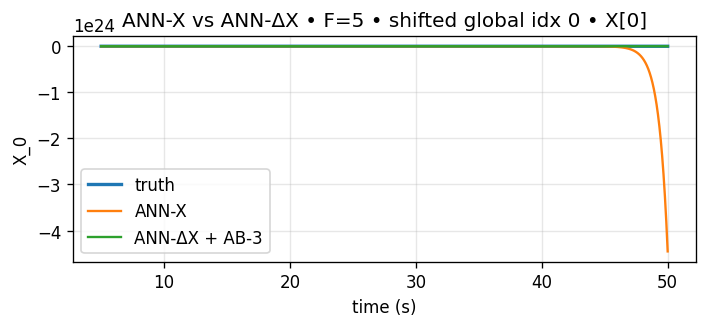

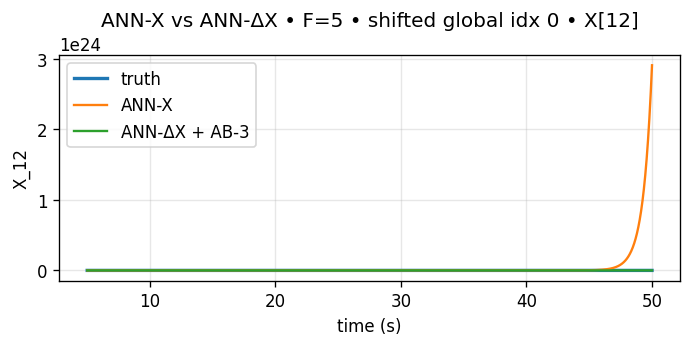

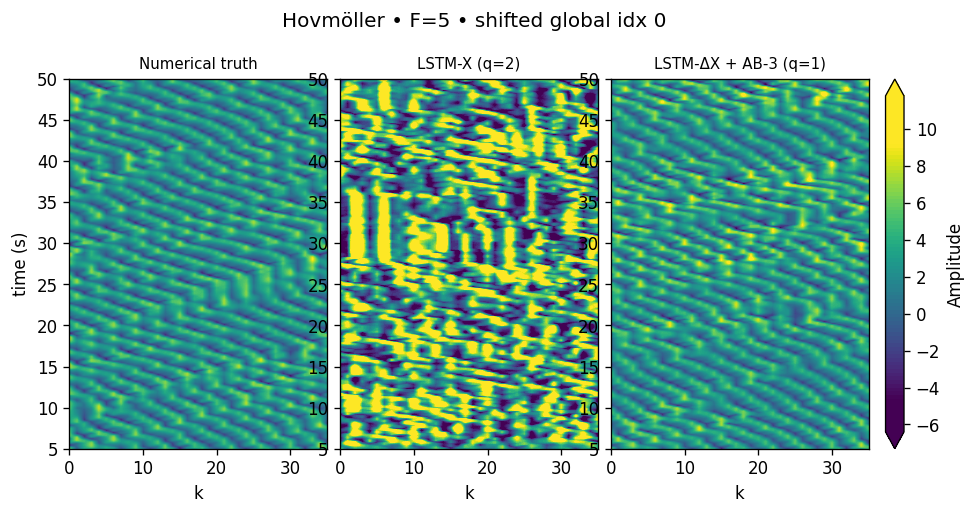

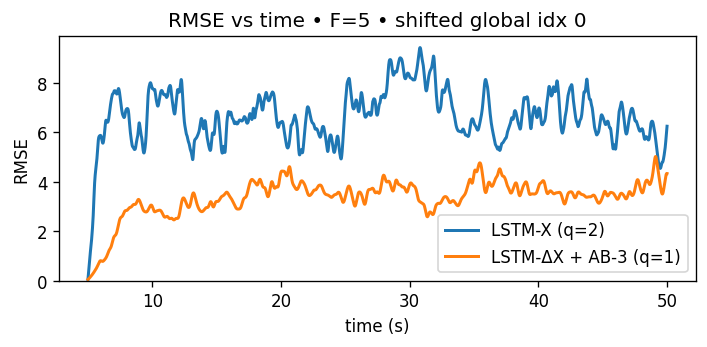

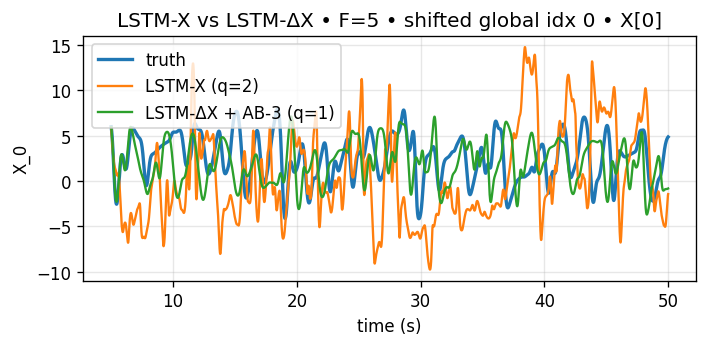

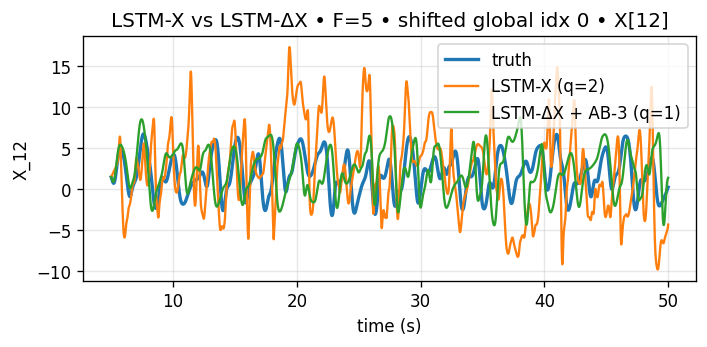

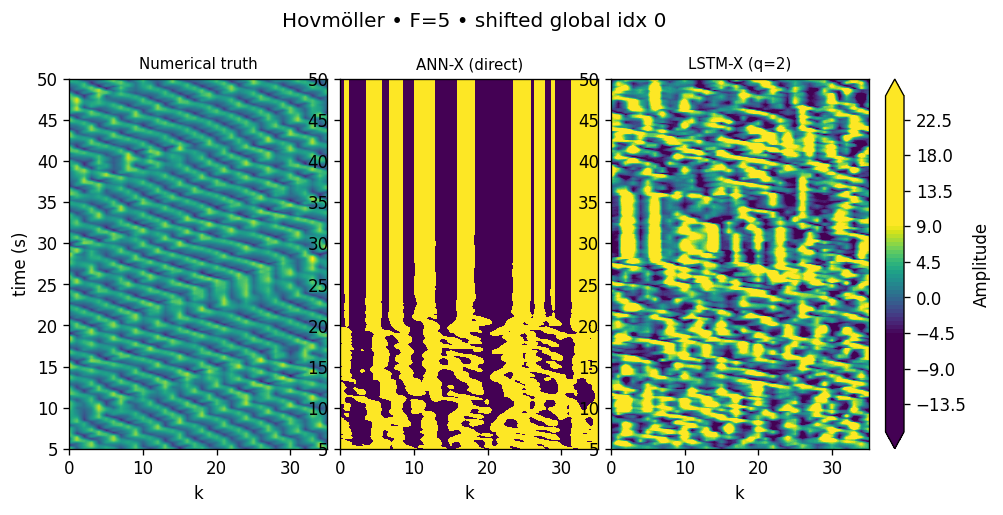

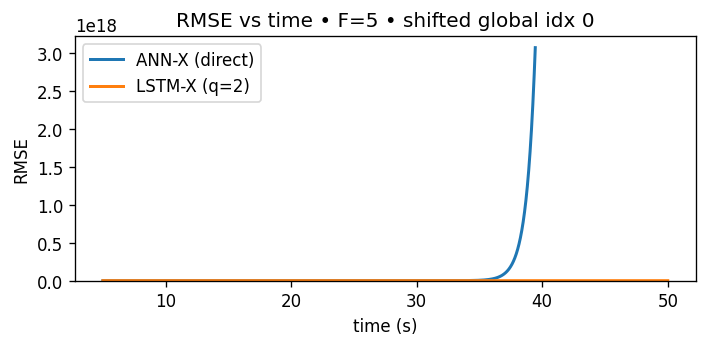

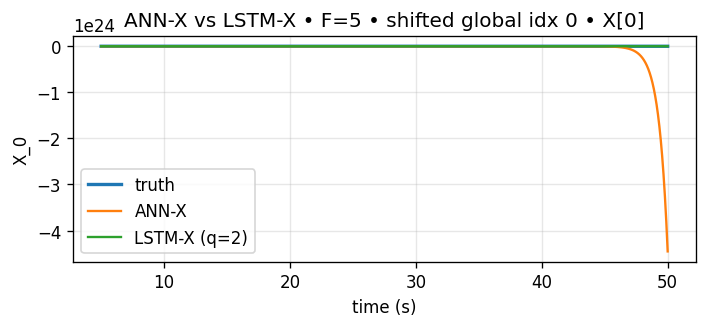

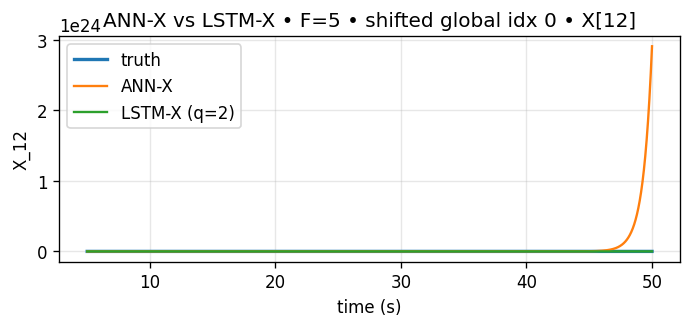

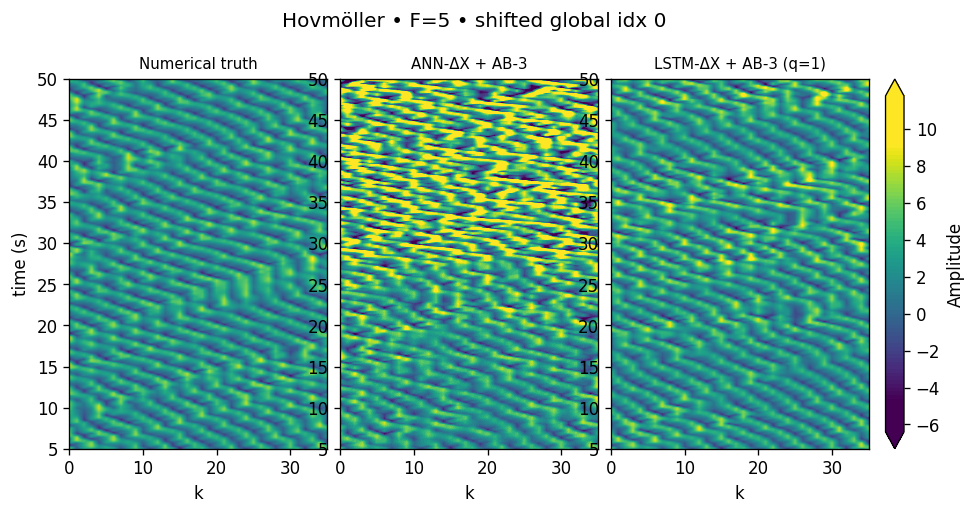

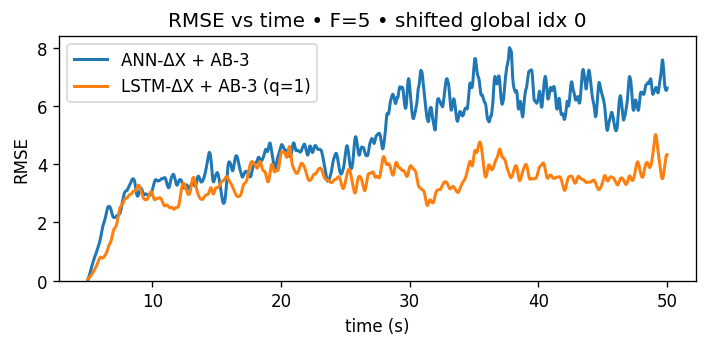

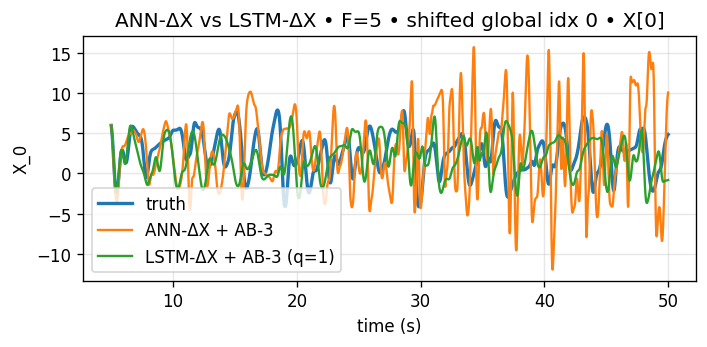

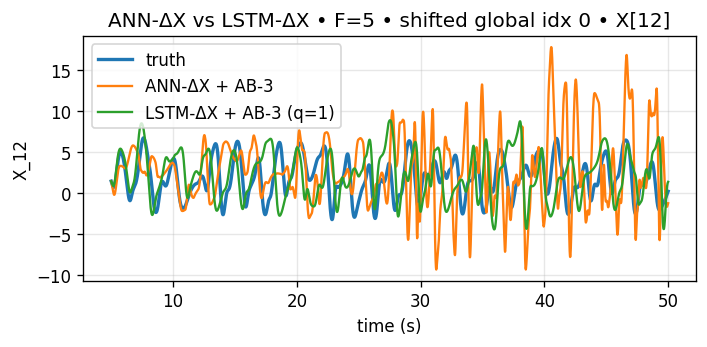


Computing ensemble-mean MAE(t) over 20 shifted trajectories (F=5) …


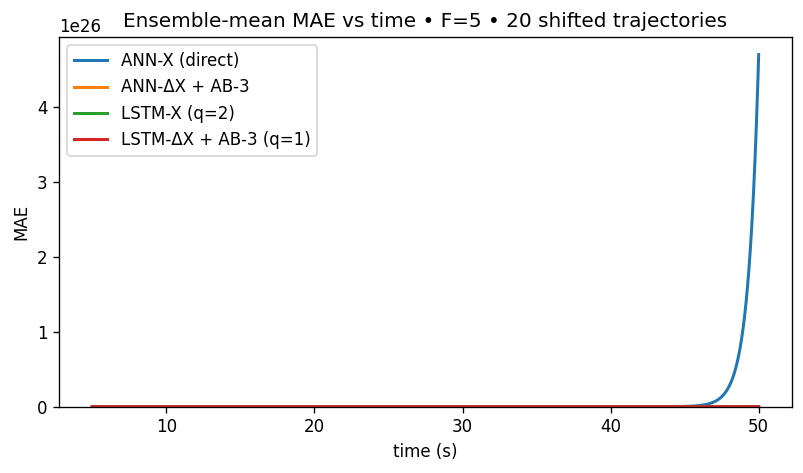


Done. (F=5 quantitative panels complete.)


In [1]:
# =============================================================================
#  Quantitative comparison suite (multiple-implicit; F = 5 only)
#  -----------------------------------------------------------------------------
#  For F = 5, this cell:
#    (1) NUM vs ANN-X vs ANN-ΔX      — Hovmöller; RMSE(t); X[k] traces
#    (2) NUM vs LSTM-X vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#    (3) NUM vs ANN-X vs LSTM-X      — Hovmöller; RMSE(t); X[k] traces
#    (4) NUM vs ANN-ΔX vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#    (5) Ensemble-mean MAE(t) over 20 shifted trajectories (F=5)
#
#  Dataset:
#    shifted_force5_10_15_data.npz with:
#      X : (traj, step, 36)  — numerical truth (mixed F)
#      F : (traj,) in {5,10,15}  — per-trajectory forcing label
#
#  Models: mixed-F ("multiple-implicit") checkpoints.
#    LSTM-X : standard_early_stopping_force5_10_15_LSTM_H70_q2.pt
#    LSTM-dX: standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt
#    (q is read from ckpt metadata or filename; no manual q required.)
# =============================================================================

import os, re, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ────────────────────────── USER CONFIG ────────────────────────────────────
FORCE_LABEL       = 5                   # label for figure titles
DT, T0, T1        = 0.005, 5.0, 50.0   # ← adjust T1 here to change horizon
K_TO_PLOT         = (0, 12)             # two components for line plots
TRAJ_IDX_LOCAL    = 0                   # which F=5 trajectory to showcase (0-based within F-subset)

# Data files (mixed-F)
TRAIN_FILE_MIXED  = "force_5_10_15_data.npz"          # μ/σ fallback
SHIFTED_FILE      = "shifted_force5_10_15_data.npz"   # combined shifted dataset (X, F)

# Checkpoints (multiple-implicit; adjust paths/names if needed)
CKPT_ANN_X        = "standard_early_stopping_F5_10_15_annX.pt"          # ANN-X (direct X̂)
CKPT_ANN_DX       = "standard_early_stopping_F5_10_15_ann.pt"           # ANN-ΔX (ΔX̂; AB3 in z)
CKPT_LSTM_X       = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"   # LSTM-X (best q)
CKPT_LSTM_DX      = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"# LSTM-ΔX (best q)

# ────────────────────────── DEVICE ─────────────────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ────────────────────────── TIME AXES ──────────────────────────────────────
steps_per_s = int(round(1/DT))
i0, i_end   = int(T0*steps_per_s), int(T1*steps_per_s)   # inclusive span
t_axis      = np.arange(i0, i_end+1, dtype=np.float32) * DT

# ────────────────────────── HELPERS ────────────────────────────────────────
def find_state_dict(obj):
    """Locate a state_dict in a checkpoint object."""
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, (torch.Tensor, np.ndarray)) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = find_state_dict(v)
                if sd is not None:
                    return sd
    return None

def get_q_from_ckpt_or_name(raw_obj, path: str):
    """Return lookback q from checkpoint dict metadata or parse from filename '_q{q}.pt'."""
    q = None
    if isinstance(raw_obj, dict):
        for k in ("lookback","q","q_len","window"):
            if k in raw_obj and raw_obj[k] is not None:
                try:
                    q = int(raw_obj[k])
                    break
                except Exception:
                    pass
    if q is None:
        m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
        if m: q = int(m.group(1))
    if q is None:
        raise ValueError(
            f"Could not determine lookback q for '{os.path.basename(path)}'. "
            "Please store 'lookback' in the checkpoint or include '_q{q}' in the filename."
        )
    return q

# Adam–Bashforth 3 in z-space (Euler → AB2 → AB3)
def ab3(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:  # Euler
        return dx1
    if dx_prev2 is None:  # AB2
        return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

# ────────────────────────── MODELS ─────────────────────────────────────────
def make_mlp(sizes=(36,128,128,64,36), act="relu"):
    acts = dict(tanh=nn.Tanh, relu=nn.ReLU, gelu=nn.GELU)
    layers = []
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes)-2:
            layers.append(acts[act]())
    return nn.Sequential(*layers)

class LSTM_X(nn.Module):
    """One-layer LSTM that outputs next-state X̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):               # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])       # (B,N)

class LSTM_dX(nn.Module):
    """One-layer LSTM that outputs ΔX̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):               # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])       # (B,N) ΔX̂

# ────────────────────────── MIXED μ/σ FALLBACK ────────────────────────────
train_mixed = np.load(TRAIN_FILE_MIXED)["X"].astype(np.float32).reshape(-1, 36)
MU_FALL = train_mixed.mean(0).astype(np.float32)
SD_FALL = (train_mixed.std(0) + 1e-8).astype(np.float32)

# ────────────────────────── LOAD CHECKPOINTS ───────────────────────────────
# ANN-X
annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
ann_x = make_mlp().to(DEVICE).eval()
ann_x.load_state_dict(annx_ckpt.get("net", annx_ckpt))
mu_annx = annx_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annx = annx_ckpt.get("std",  SD_FALL).astype(np.float32)

# ANN-ΔX
annd_ckpt = torch.load(CKPT_ANN_DX, map_location="cpu")
ann_dx = make_mlp().to(DEVICE).eval()
ann_dx.load_state_dict(annd_ckpt.get("net", annd_ckpt))
mu_annd = annd_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annd = annd_ckpt.get("std",  SD_FALL).astype(np.float32)

# LSTM-X
lstm_x_raw = torch.load(CKPT_LSTM_X, map_location="cpu")
sd_xdict   = find_state_dict(lstm_x_raw)
if sd_xdict is None:
    raise RuntimeError(f"Could not find state-dict in LSTM-X checkpoint: {CKPT_LSTM_X}")
hidden_x   = int(lstm_x_raw.get("hidden_size", 70)) if isinstance(lstm_x_raw, dict) else 70
q_x        = get_q_from_ckpt_or_name(lstm_x_raw, CKPT_LSTM_X)
lstm_x     = LSTM_X(hidden_x, n=36).to(DEVICE).eval()
lstm_x.load_state_dict(sd_xdict)
mu_lx = (lstm_x_raw.get("mean", MU_FALL) if isinstance(lstm_x_raw, dict) else MU_FALL).astype(np.float32)
sd_lx = (lstm_x_raw.get("std",  SD_FALL) if isinstance(lstm_x_raw, dict) else SD_FALL).astype(np.float32)

# LSTM-ΔX
lstm_dx_raw = torch.load(CKPT_LSTM_DX, map_location="cpu")
sd_dxdict   = find_state_dict(lstm_dx_raw)
if sd_dxdict is None:
    raise RuntimeError(f"Could not find state-dict in LSTM-ΔX checkpoint: {CKPT_LSTM_DX}")
hidden_dx   = int(lstm_dx_raw.get("hidden_size", 70)) if isinstance(lstm_dx_raw, dict) else 70
q_dx        = get_q_from_ckpt_or_name(lstm_dx_raw, CKPT_LSTM_DX)
lstm_dx     = LSTM_dX(hidden_dx, n=36).to(DEVICE).eval()
lstm_dx.load_state_dict(sd_dxdict)
mu_ldx = (lstm_dx_raw.get("mean", MU_FALL) if isinstance(lstm_dx_raw, dict) else MU_FALL).astype(np.float32)
sd_ldx = (lstm_dx_raw.get("std",  SD_FALL) if isinstance(lstm_dx_raw, dict) else SD_FALL).astype(np.float32)

# ────────────────────────── LOAD SHIFTED FILE & FILTER F=5 ────────────────
shifted = np.load(SHIFTED_FILE)
X_shift_all = shifted["X"].astype(np.float32)        # (traj, step, 36)
F_shift_all = shifted["F"].astype(np.int32)          # (traj,)
_, N_STEPS, N = X_shift_all.shape
assert i_end + 1 <= N_STEPS, "Requested [T0, T1] exceeds shifted data length"

idx_f5 = np.where(F_shift_all == 5)[0]
assert len(idx_f5) > 0, "No shifted trajectories found for F=5"
X_F = X_shift_all[idx_f5]                            # (n_f, step, 36)
assert 0 <= TRAJ_IDX_LOCAL < len(X_F), f"TRAJ_IDX_LOCAL={TRAJ_IDX_LOCAL} out of range for F=5 subset"

truth_fixed = X_F[TRAJ_IDX_LOCAL, i0:i_end+1]        # (T,N)

# ────────────────────────── ROLLOUT HELPERS ───────────────────────────────
@torch.no_grad()
def rollout_ann_x(traj_phys, mu, sdv):
    """ANN-X: direct X̂(t+Δt) in z-space, autoregressive, no AB."""
    prev_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)  # z(X at t0-Δt)
    prev   = torch.from_numpy(prev_z).to(DEVICE)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    for _ in range(i0, i_end+1):
        nxt_z = ann_x(prev.unsqueeze(0))                        # (1,N)
        preds.append((nxt_z * sd_t + mu_t).squeeze(0).cpu().numpy())
        prev = nxt_z.squeeze(0)
    return np.stack(preds)                                      # (T,N)

@torch.no_grad()
def rollout_ann_dx(traj_phys, mu, sdv):
    """ANN-ΔX: ΔX̂ with AB3 in z-space."""
    x_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)     # z at t0-Δt
    x   = torch.from_numpy(x_z).to(DEVICE)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    dx_prev1 = dx_prev2 = None
    for _ in range(i0, i_end+1):
        dx1  = ann_dx(x.unsqueeze(0))                           # (1,N)
        step = ab3(dx1, dx_prev1, dx_prev2)                     # (1,N)
        x    = x + step.squeeze(0)
        preds.append((x * sd_t + mu_t).cpu().numpy())
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)                                      # (T,N)

@torch.no_grad()
def rollout_lstm_x(traj_phys, net, q, mu, sdv):
    """LSTM-X: uses true history window [t0-q+1 … t0] in z; predicts X̂(t0+Δt); slides."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)  # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)              # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    for _ in range(i0, i_end+1):
        y = net(win)                                                 # (1,N)
        preds.append((y * sd_t + mu_t).squeeze(0).cpu().numpy())     # (N,)
        win = torch.cat([win[:,1:,:], y.unsqueeze(1)], dim=1)        # slide
    return np.stack(preds)                                           # (T,N)

@torch.no_grad()
def rollout_lstm_dx(traj_phys, net, q, mu, sdv):
    """LSTM-ΔX: ΔX̂ with AB3 in z-space; history window [t0-q+1 … t0] in z; slides with new_z."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)   # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)               # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds = []
    dx_prev1 = dx_prev2 = None
    for _ in range(i0, i_end+1):
        dx1  = net(win)                                              # (1,N)
        step = ab3(dx1, dx_prev1, dx_prev2)                          # (1,N)
        new_z = win[:, -1, :] + step                                 # (1,N)
        preds.append((new_z * sd_t + mu_t).squeeze(0).cpu().numpy()) # (N,)
        win = torch.cat([win[:,1:,:], new_z.unsqueeze(1)], dim=1)    # slide
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)                                           # (T,N)

def rmse_t(pred, truth): return np.sqrt(((pred - truth)**2).mean(axis=1))
def mae_t (pred, truth): return np.abs (pred - truth).mean(axis=1)

# ────────────────────────── PLOTTING HELPERS ─────────────────────────────
def hovmoller(t_axis, truth, pred1, pred2, lab1, lab2, suptitle):
    vmin, vmax = truth.min(), truth.max()
    k_axis = np.arange(truth.shape[1])
    fig, axs = plt.subplots(1, 3, figsize=(9, 4), dpi=120, gridspec_kw={"wspace":0.05})
    for ax, mat, ttl in zip(axs, (truth, pred1, pred2), ("Numerical truth", lab1, lab2)):
        cf = ax.contourf(k_axis, t_axis, mat, 100, cmap="viridis",
                         vmin=vmin, vmax=vmax, extend="both")
        ax.set_xlabel("k"); ax.set_ylim(t_axis[0], t_axis[-1])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(ttl, fontsize=9)
    axs[0].set_ylabel("time (s)")
    fig.colorbar(cf, ax=axs, fraction=0.025, pad=0.02, label="Amplitude")
    fig.suptitle(suptitle, y=1.02)
    plt.tight_layout(); plt.show()

def plot_rmse(t_axis, rmse1, rmse2, lab1, lab2, title):
    plt.figure(figsize=(6,3), dpi=120)
    plt.plot(t_axis, rmse1, lw=1.8, label=lab1)
    plt.plot(t_axis, rmse2, lw=1.8, label=lab2)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE"); plt.ylim(0); plt.legend()
    plt.tight_layout(); plt.show()

def plot_traces(t_axis, truth, pred1, pred2, k_pair, lab1, lab2, title):
    for k in k_pair:
        plt.figure(figsize=(6,3), dpi=120)
        plt.plot(t_axis, truth[:,k], lw=2.0, label="truth")
        plt.plot(t_axis, pred1[:,k], lw=1.4, label=lab1)
        plt.plot(t_axis, pred2[:,k], lw=1.4, label=lab2)
        plt.title(f"{title} • X[{k}]")
        plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ────────────────────────── PREDICT (representative F=5 trajectory) ───────
ann_x_pred   = rollout_ann_x (X_F[TRAJ_IDX_LOCAL], mu_annx, sd_annx)
ann_dx_pred  = rollout_ann_dx(X_F[TRAJ_IDX_LOCAL], mu_annd, sd_annd)
lstm_x_pred  = rollout_lstm_x (X_F[TRAJ_IDX_LOCAL], lstm_x,  q_x,  mu_lx,  sd_lx)
lstm_dx_pred = rollout_lstm_dx(X_F[TRAJ_IDX_LOCAL], lstm_dx, q_dx, mu_ldx, sd_ldx)

# shape guards
for name, arr in [("ann_x_pred", ann_x_pred), ("ann_dx_pred", ann_dx_pred),
                  ("lstm_x_pred", lstm_x_pred), ("lstm_dx_pred", lstm_dx_pred)]:
    assert arr.shape == truth_fixed.shape, f"{name} shape {arr.shape}, expected {truth_fixed.shape}"

# ────────────────────────── PANELS (1)–(4) ────────────────────────────────
global_idx = int(idx_f5[TRAJ_IDX_LOCAL])  # original global index in the mixed file

# (1) ANN-X vs ANN-ΔX
hovmoller(t_axis, truth_fixed, ann_x_pred, ann_dx_pred,
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(ann_dx_pred, truth_fixed),
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_traces(t_axis, truth_fixed, ann_x_pred, ann_dx_pred, K_TO_PLOT,
            "ANN-X", "ANN-ΔX + AB-3",
            f"ANN-X vs ANN-ΔX • F={FORCE_LABEL} • shifted global idx {global_idx}")

# (2) LSTM-X vs LSTM-ΔX
hovmoller(t_axis, truth_fixed, lstm_x_pred, lstm_dx_pred,
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_rmse(t_axis, rmse_t(lstm_x_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_traces(t_axis, truth_fixed, lstm_x_pred, lstm_dx_pred, K_TO_PLOT,
            f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"LSTM-X vs LSTM-ΔX • F={FORCE_LABEL} • shifted global idx {global_idx}")

# (3) ANN-X vs LSTM-X
hovmoller(t_axis, truth_fixed, ann_x_pred, lstm_x_pred,
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(lstm_x_pred, truth_fixed),
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_traces(t_axis, truth_fixed, ann_x_pred, lstm_x_pred, K_TO_PLOT,
            "ANN-X", f"LSTM-X (q={q_x})",
            f"ANN-X vs LSTM-X • F={FORCE_LABEL} • shifted global idx {global_idx}")

# (4) ANN-ΔX vs LSTM-ΔX
hovmoller(t_axis, truth_fixed, ann_dx_pred, lstm_dx_pred,
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_rmse(t_axis, rmse_t(ann_dx_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_idx}")
plot_traces(t_axis, truth_fixed, ann_dx_pred, lstm_dx_pred, K_TO_PLOT,
            "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"ANN-ΔX vs LSTM-ΔX • F={FORCE_LABEL} • shifted global idx {global_idx}")

# ────────────────────────── (5) ENSEMBLE-MEAN MAE(t) over 20 (F=5) ────────
n_local = len(X_F)
n_eval  = min(20, n_local)
TEST_IDS_LOCAL = list(range(n_eval))

mae_annx_list, mae_annd_list, mae_lx_list, mae_ldx_list = [], [], [], []
print(f"\nComputing ensemble-mean MAE(t) over {n_eval} shifted trajectories (F=5) …")

for local_id in TEST_IDS_LOCAL:
    traj  = X_F[local_id]
    truth = traj[i0:i_end+1]

    pred_annx = rollout_ann_x (traj, mu_annx, sd_annx)
    pred_annd = rollout_ann_dx(traj, mu_annd, sd_annd)
    pred_lx   = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)
    pred_ldx  = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)

    mae_annx_list.append(mae_t(pred_annx, truth))
    mae_annd_list.append(mae_t(pred_annd, truth))
    mae_lx_list  .append(mae_t(pred_lx,   truth))
    mae_ldx_list .append(mae_t(pred_ldx,  truth))

mae_annx = np.stack(mae_annx_list).mean(0)
mae_annd = np.stack(mae_annd_list).mean(0)
mae_lx   = np.stack(mae_lx_list  ).mean(0)
mae_ldx  = np.stack(mae_ldx_list ).mean(0)

plt.figure(figsize=(6.8,4.2), dpi=120)
plt.plot(t_axis, mae_annx, lw=1.8, label="ANN-X (direct)")
plt.plot(t_axis, mae_annd, lw=1.8, label="ANN-ΔX + AB-3")
plt.plot(t_axis, mae_lx,   lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx,  lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {n_eval} shifted trajectories")
plt.xlabel("time (s)"); plt.ylabel("MAE"); plt.ylim(0); plt.legend()
plt.tight_layout(); plt.show()

print("\nDone. (F=5 quantitative panels complete.)")



Computing ensemble-mean MAE(t) over 20 shifted trajectories (F=5) …


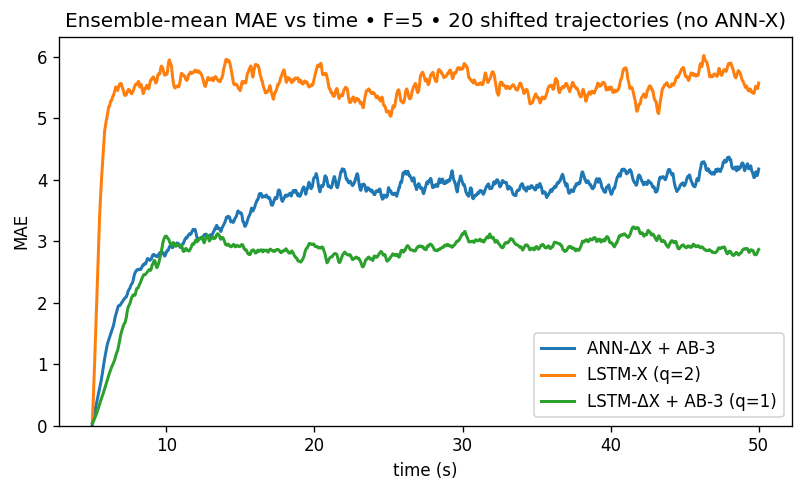

In [2]:
# =============================================================================
# Final panel: Ensemble-mean MAE(t) over 20 shifted trajectories (F subset),
#              EXCLUDING ANN-X (only ANN-ΔX, LSTM-X, LSTM-ΔX)
# -----------------------------------------------------------------------------
# Requirements from previous cell:
#   - Variables: X_F, i0, i_end, t_axis, FORCE_LABEL
#   - Rollout fns: rollout_ann_dx, rollout_lstm_x, rollout_lstm_dx
#   - Params: mu_annd, sd_annd, lstm_x, q_x, mu_lx, sd_lx, lstm_dx, q_dx, mu_ldx, sd_ldx
#   - Metric: mae_t(pred, truth)
# This cell uses the FIRST 20 trajectories in the *shifted dataset subset* X_F.
# No perturbation ensemble is used here (this is quantitative study style).
# =============================================================================

# ---- sanity checks (helps if you run cells out of order) ----
_needed = [
    "X_F","i0","i_end","t_axis","FORCE_LABEL",
    "rollout_ann_dx","rollout_lstm_x","rollout_lstm_dx",
    "mu_annd","sd_annd","lstm_x","q_x","mu_lx","sd_lx","lstm_dx","q_dx","mu_ldx","sd_ldx",
]
for _name in _needed:
    if _name not in globals():
        raise RuntimeError(f"Missing '{_name}'. Run the F=5 setup cell first.")

n_local = len(X_F)
n_eval  = min(20, n_local)
TEST_IDS_LOCAL = list(range(n_eval))

mae_annd_list, mae_lx_list, mae_ldx_list = [], [], []
print(f"\nComputing ensemble-mean MAE(t) over {n_eval} shifted trajectories (F={FORCE_LABEL}) …")

for local_id in TEST_IDS_LOCAL:
    traj  = X_F[local_id]
    truth = traj[i0:i_end+1]

    pred_annd = rollout_ann_dx(traj, mu_annd, sd_annd)                   # ANN-ΔX (+AB3)
    pred_lx   = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)      # LSTM-X (direct)
    pred_ldx  = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)     # LSTM-ΔX (+AB3)

    mae_annd_list.append(mae_t(pred_annd, truth))
    mae_lx_list  .append(mae_t(pred_lx,   truth))
    mae_ldx_list .append(mae_t(pred_ldx,  truth))

mae_annd = np.stack(mae_annd_list).mean(0)
mae_lx   = np.stack(mae_lx_list  ).mean(0)
mae_ldx  = np.stack(mae_ldx_list ).mean(0)

plt.figure(figsize=(6.8,4.2), dpi=120)
plt.plot(t_axis, mae_annd, lw=1.8, label="ANN-ΔX + AB-3")
plt.plot(t_axis, mae_lx,   lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx,  lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {n_eval} shifted trajectories (no ANN-X)")
plt.xlabel("time (s)"); plt.ylabel("MAE"); plt.ylim(0); plt.legend()
plt.tight_layout(); plt.show()


Using GPU : Quadro RTX 8000 (ID 0)
F=10: using shifted representative global_idx=1 (local=0)


/state/partition1/job-64527132/ipykernel_2912764/3706318018.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
/sta

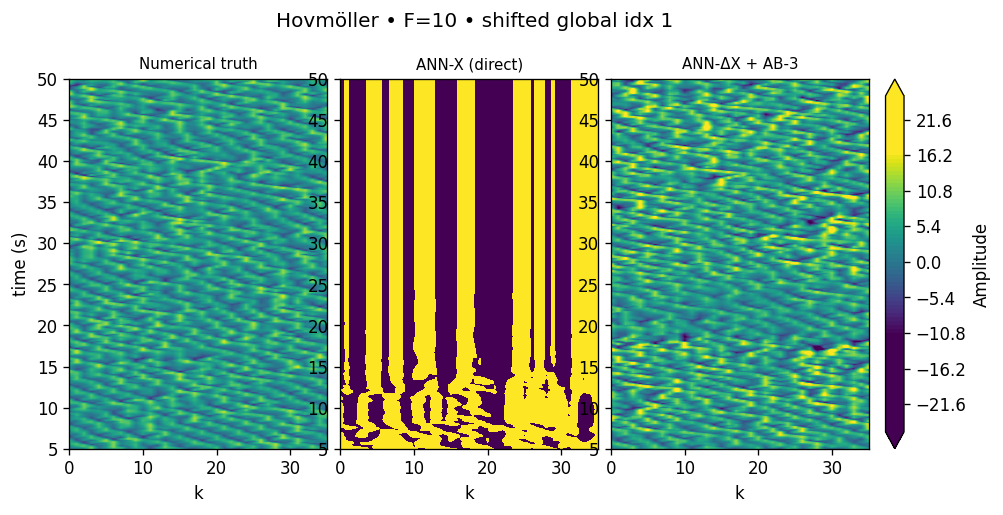

/state/partition1/job-64527132/ipykernel_2912764/3706318018.py:240: RuntimeWarning: overflow encountered in square
  def rmse_t(pred, truth): return np.sqrt(((pred - truth)**2).mean(axis=1))


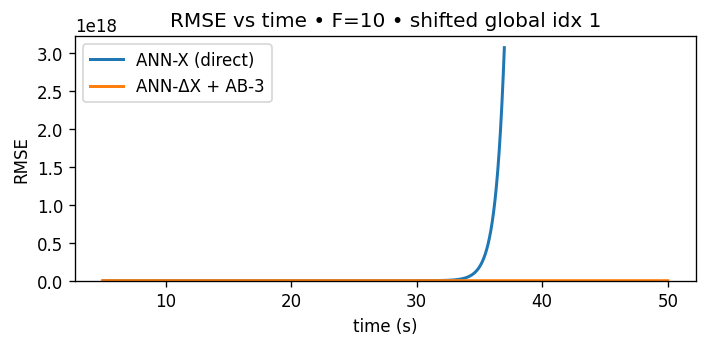

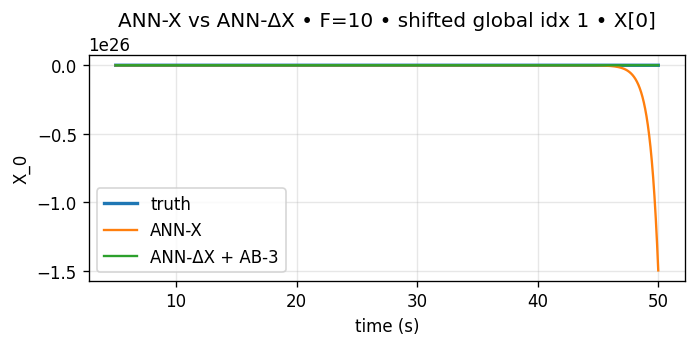

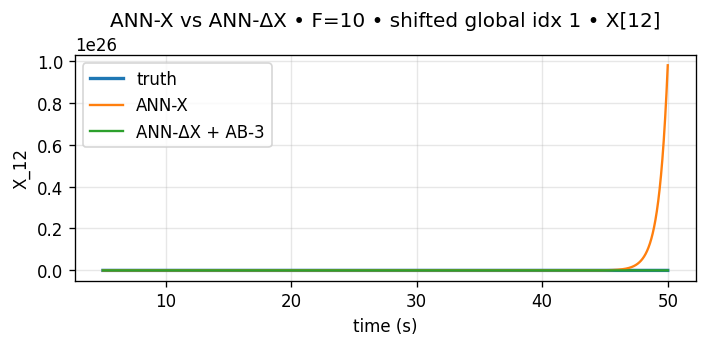

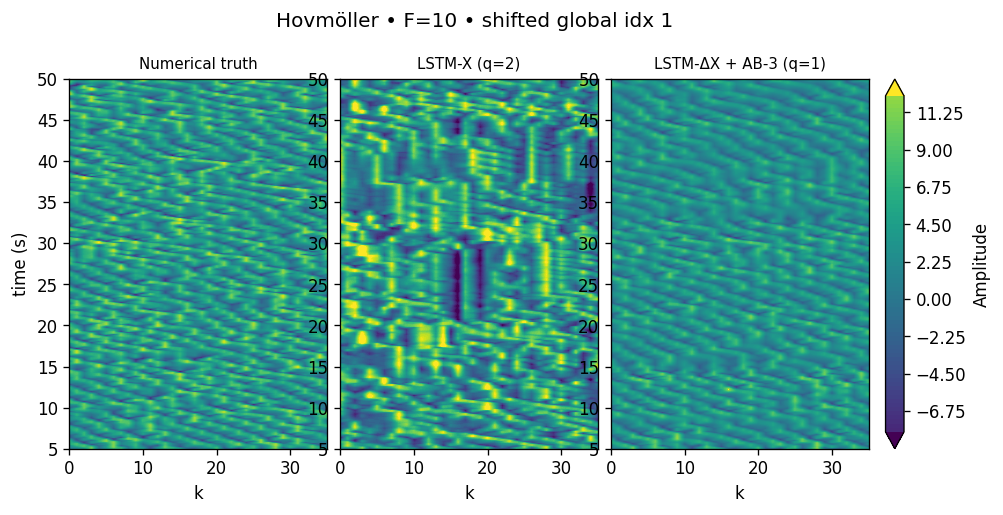

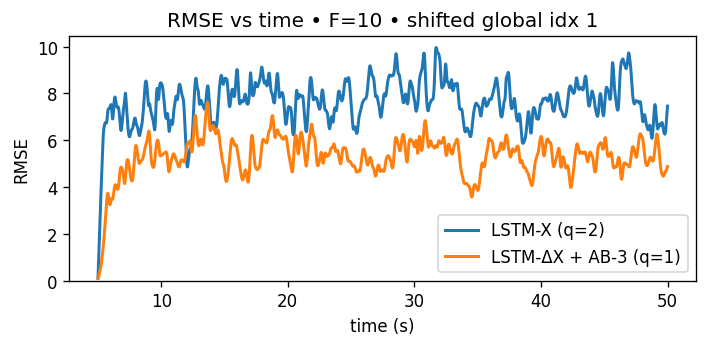

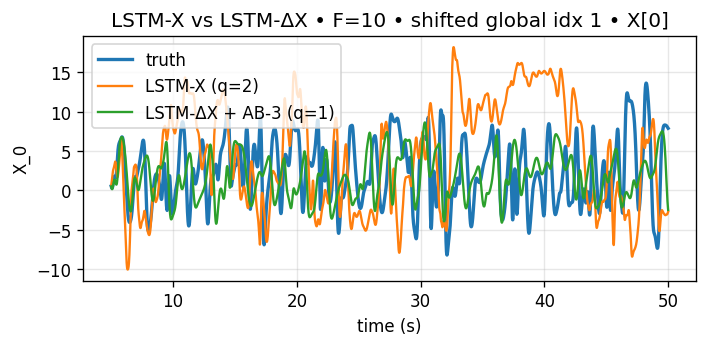

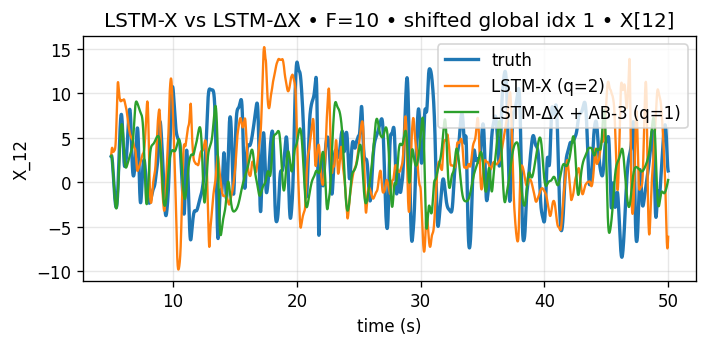

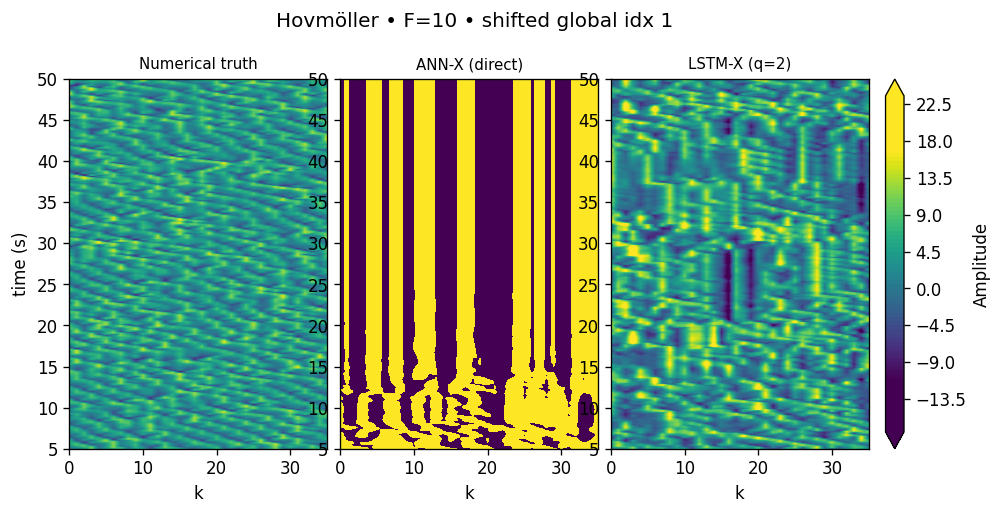

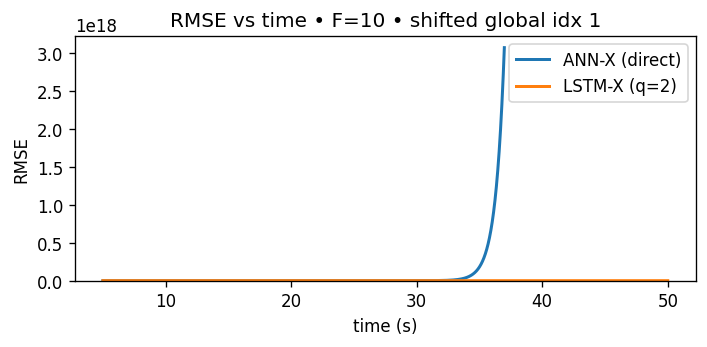

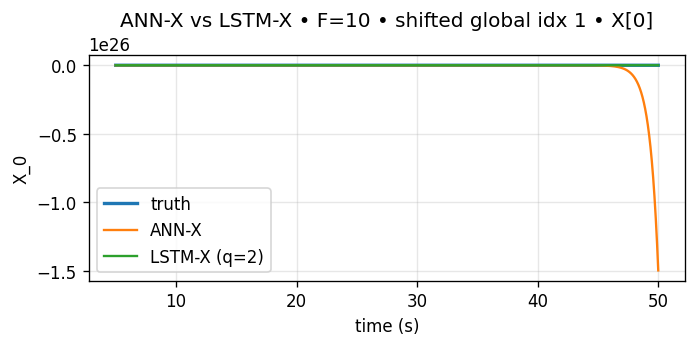

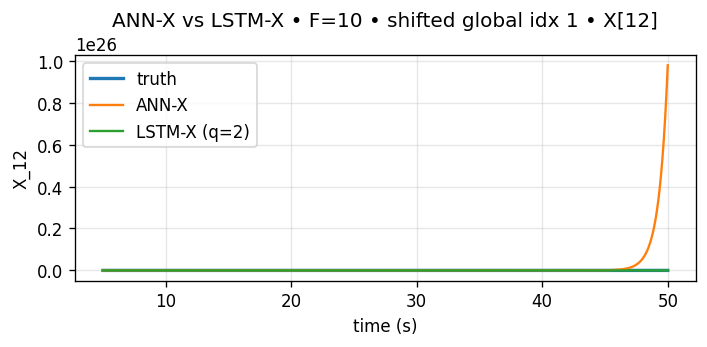

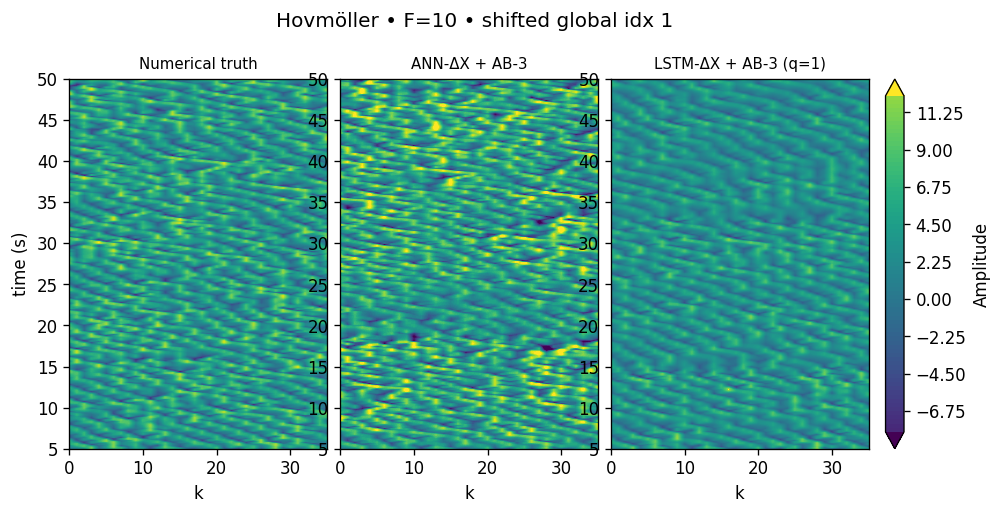

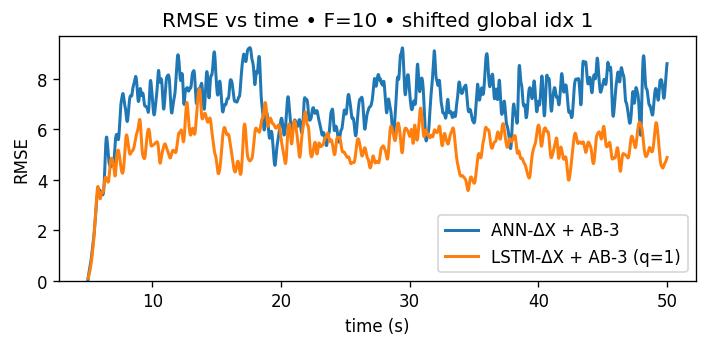

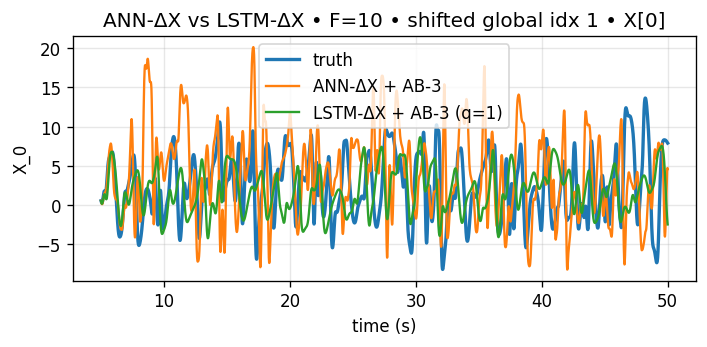

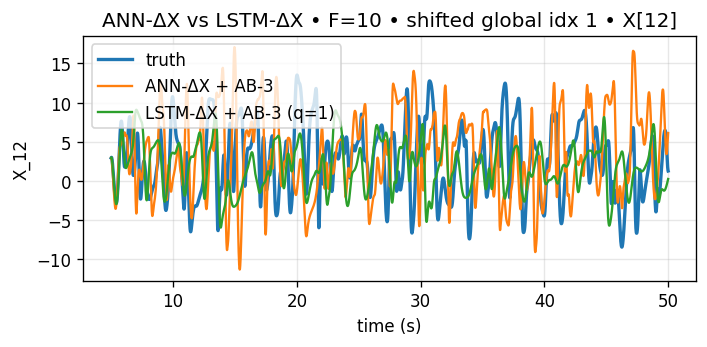


Computing ensemble-mean MAE(t) over 20 shifted trajectories (F=10) … (no ANN-X)


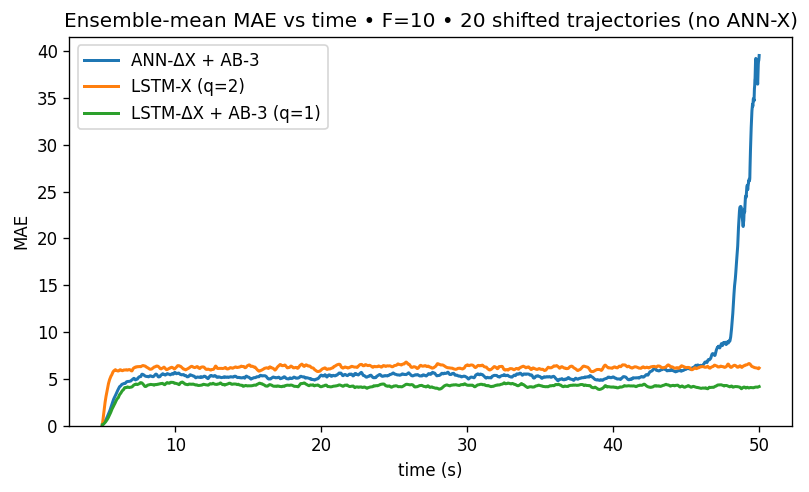


Done (F=10).


In [3]:
#!/usr/bin/env python3
# =============================================================================
#  Quantitative comparison suite (multiple-implicit; F = 10 only, merged cell)
#  -----------------------------------------------------------------------------
#  Does for ONE representative shifted trajectory (from F=10 subset):
#    (1) NUM vs ANN-X vs ANN-ΔX      — Hovmöller; RMSE(t); X[k] traces
#    (2) NUM vs LSTM-X vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#    (3) NUM vs ANN-X vs LSTM-X      — Hovmöller; RMSE(t); X[k] traces
#    (4) NUM vs ANN-ΔX vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#  And then:
#    (5) Ensemble-mean MAE(t) over first 20 shifted trajectories in F=10 subset
#        **EXCLUDING ANN-X** (plots ANN-ΔX, LSTM-X, LSTM-ΔX only).
#
#  Notes:
#    • Uses a single mixed-F shifted file with labels; filters to F=10.
#    • ΔX models (ANN-ΔX & LSTM-ΔX) are integrated via Euler→AB2→AB3 **in z-space**.
#    • Direct X models (ANN-X & LSTM-X) predict X̂(t+Δt) (no AB).
#    • All predictions autoregressive; denormalise to physical space before metrics.
#    • q (lookback) is read from LSTM checkpoint metadata or filename “_q{q}.pt”.
#    • EASY KNOBS below: TRAJ_LOCAL_IDX, DT, T0, T_END, K_TO_PLOT.
# =============================================================================

import os, re, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ────────────────────────── EASY KNOBS ─────────────────────────────────────
FORCE_LABEL     = 10                 # Which forcing to analyse (fixed in this cell)
TRAJ_LOCAL_IDX  = 0                  # Which trajectory within the F=10 subset to showcase (0-based)
DT, T0, T_END   = 0.005, 5.0, 50.0   # Time step, start time, end time
K_TO_PLOT       = (0, 12)            # Two components to show in line plots
# File names (adjust if your names differ)
TRAIN_FILE_MIXED  = "force_5_10_15_data.npz"           # μ/σ fallback (mixed-F training)
SHIFTED_FILE      = "shifted_force5_10_15_data.npz"    # mixed-F shifted set with labels
CKPT_ANN_X        = "standard_early_stopping_F5_10_15_annX.pt"       # ANN-X (direct)
CKPT_ANN_DX       = "standard_early_stopping_F5_10_15_ann.pt"        # ANN-ΔX (delta)
CKPT_LSTM_X       = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"   # LSTM-X
CKPT_LSTM_DX      = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt" # LSTM-ΔX

# ────────────────────────── DEVICE ─────────────────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ────────────────────────── TIME AXES ──────────────────────────────────────
steps_per_s = int(round(1/DT))
i0, i_end   = int(T0*steps_per_s), int(T_END*steps_per_s)  # inclusive span
t_axis      = np.arange(i0, i_end+1, dtype=np.float32) * DT
assert i_end > i0, "T_END must be > T0."

# ────────────────────────── HELPERS ────────────────────────────────────────
def parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def find_state_dict(obj):
    """Locate a state_dict in a checkpoint object."""
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, (torch.Tensor, np.ndarray)) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = find_state_dict(v); 
                if sd is not None: return sd
    return None

# AB-3 in z-space (Euler→AB2→AB3)
def ab3(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:  return dx1
    if dx_prev2 is None:  return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

# ────────────────────────── MODELS ─────────────────────────────────────────
def make_mlp(sizes=(36,128,128,64,36), act="relu"):
    acts = dict(tanh=nn.Tanh, relu=nn.ReLU, gelu=nn.GELU)
    layers = []
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes)-2:
            layers.append(acts[act]())
    return nn.Sequential(*layers)

class LSTM_X(nn.Module):
    """One-layer LSTM that outputs next-state X̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):              # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])      # (B,N)

class LSTM_dX(nn.Module):
    """One-layer LSTM that outputs ΔX̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):              # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])      # (B,N) ΔX̂

# ────────────────────────── LOAD DATASETS ─────────────────────────────────
# μ/σ fallback from mixed training set
train_mixed = np.load(TRAIN_FILE_MIXED)["X"].astype(np.float32).reshape(-1, 36)
MU_FALL = train_mixed.mean(0).astype(np.float32)
SD_FALL = (train_mixed.std(0) + 1e-8).astype(np.float32)

# Load mixed-F shifted file and filter to F=10
shifted = np.load(SHIFTED_FILE)
X_shift_all = shifted["X"].astype(np.float32)        # (traj, step, 36)
F_shift_all = shifted["F"].astype(np.int32)          # (traj,)
_, N_STEPS, N = X_shift_all.shape
assert i_end + 1 <= N_STEPS, "Requested [T0,T_END] exceeds shifted data length."

idx_f = np.where(F_shift_all == FORCE_LABEL)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={FORCE_LABEL}"
X_F = X_shift_all[idx_f]                              # (n_f, step, 36)
assert 0 <= TRAJ_LOCAL_IDX < len(X_F), f"TRAJ_LOCAL_IDX out of range (0..{len(X_F)-1})"
global_id = int(idx_f[TRAJ_LOCAL_IDX])

print(f"F={FORCE_LABEL}: using shifted representative global_idx={global_id} (local={TRAJ_LOCAL_IDX})")

# Truth slice for the representative trajectory
truth_fixed = X_F[TRAJ_LOCAL_IDX, i0:i_end+1]        # (T,N)

# ────────────────────────── LOAD CHECKPOINTS ───────────────────────────────
# ANN-X
annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
ann_x = make_mlp().to(DEVICE).eval()
ann_x.load_state_dict(annx_ckpt.get("net", annx_ckpt))
mu_annx = annx_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annx = annx_ckpt.get("std",  SD_FALL).astype(np.float32)

# ANN-ΔX
annd_ckpt = torch.load(CKPT_ANN_DX, map_location="cpu")
ann_dx = make_mlp().to(DEVICE).eval()
ann_dx.load_state_dict(annd_ckpt.get("net", annd_ckpt))
mu_annd = annd_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annd = annd_ckpt.get("std",  SD_FALL).astype(np.float32)

# LSTM-X
lstm_x_raw = torch.load(CKPT_LSTM_X, map_location="cpu")
sd_xdict   = find_state_dict(lstm_x_raw)
if sd_xdict is None:
    raise RuntimeError(f"Could not find state-dict in LSTM-X checkpoint: {CKPT_LSTM_X}")
hidden_x   = int(lstm_x_raw.get("hidden_size", 70)) if isinstance(lstm_x_raw, dict) else 70
q_x_meta   = int(lstm_x_raw.get("lookback")) if isinstance(lstm_x_raw, dict) and ("lookback" in lstm_x_raw) else None
q_x        = q_x_meta or parse_q_from_filename(CKPT_LSTM_X)
if q_x is None:
    raise ValueError("Cannot determine q for LSTM-X. Rename file with _q{q}.pt or store 'lookback' in ckpt.")
lstm_x = LSTM_X(hidden_x, n=N).to(DEVICE).eval()
lstm_x.load_state_dict(sd_xdict)
mu_lx = (lstm_x_raw.get("mean", MU_FALL) if isinstance(lstm_x_raw, dict) else MU_FALL).astype(np.float32)
sd_lx = (lstm_x_raw.get("std",  SD_FALL) if isinstance(lstm_x_raw, dict) else SD_FALL).astype(np.float32)

# LSTM-ΔX
lstm_dx_raw = torch.load(CKPT_LSTM_DX, map_location="cpu")
sd_dxdict   = find_state_dict(lstm_dx_raw)
if sd_dxdict is None:
    raise RuntimeError(f"Could not find state-dict in LSTM-ΔX checkpoint: {CKPT_LSTM_DX}")
hidden_dx   = int(lstm_dx_raw.get("hidden_size", 70)) if isinstance(lstm_dx_raw, dict) else 70
q_dx_meta   = int(lstm_dx_raw.get("lookback")) if isinstance(lstm_dx_raw, dict) and ("lookback" in lstm_dx_raw) else None
q_dx        = q_dx_meta or parse_q_from_filename(CKPT_LSTM_DX)
if q_dx is None:
    raise ValueError("Cannot determine q for LSTM-ΔX. Rename file with _q{q}.pt or store 'lookback' in ckpt.")
lstm_dx = LSTM_dX(hidden_dx, n=N).to(DEVICE).eval()
lstm_dx.load_state_dict(sd_dxdict)
mu_ldx = (lstm_dx_raw.get("mean", MU_FALL) if isinstance(lstm_dx_raw, dict) else MU_FALL).astype(np.float32)
sd_ldx = (lstm_dx_raw.get("std",  SD_FALL) if isinstance(lstm_dx_raw, dict) else SD_FALL).astype(np.float32)

# ────────────────────────── ROLLOUT HELPERS ───────────────────────────────
@torch.no_grad()
def rollout_ann_x(traj_phys, mu, sdv):
    """ANN-X: X̂(t+Δt) in z-space, autoregressive, no AB."""
    prev_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)
    prev   = torch.from_numpy(prev_z).to(DEVICE)
    mu_t   = torch.from_numpy(mu).to(DEVICE)
    sd_t   = torch.from_numpy(sdv).to(DEVICE)
    preds=[]
    for _ in range(i0, i_end+1):
        nxt_z = ann_x(prev.unsqueeze(0))                        # (1,N)
        preds.append((nxt_z * sd_t + mu_t).squeeze(0).cpu().numpy())
        prev = nxt_z.squeeze(0)
    return np.stack(preds)

@torch.no_grad()
def rollout_ann_dx(traj_phys, mu, sdv):
    """ANN-ΔX: AB3 in z-space on ΔX̂."""
    x_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)
    x   = torch.from_numpy(x_z).to(DEVICE)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds=[]; dx_prev1=dx_prev2=None
    for _ in range(i0, i_end+1):
        dx1  = ann_dx(x.unsqueeze(0))                           # (1,N)
        step = ab3(dx1, dx_prev1, dx_prev2)
        x    = x + step.squeeze(0)
        preds.append((x * sd_t + mu_t).cpu().numpy())
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)

@torch.no_grad()
def rollout_lstm_x(traj_phys, net, q, mu, sdv):
    """LSTM-X: true history window [t0-q+1 … t0] in z; predicts X̂(t0+Δt); slide."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)  # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)              # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE); sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds=[]
    for _ in range(i0, i_end+1):
        y = net(win)                                                 # (1,N)
        preds.append((y * sd_t + mu_t).squeeze(0).cpu().numpy())
        win = torch.cat([win[:,1:,:], y.unsqueeze(1)], dim=1)
    return np.stack(preds)

@torch.no_grad()
def rollout_lstm_dx(traj_phys, net, q, mu, sdv):
    """LSTM-ΔX: true history [t0-q+1 … t0] in z; ΔX̂ → AB3 in z; slide."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)   # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)               # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE); sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds=[]; dx_prev1=dx_prev2=None
    for _ in range(i0, i_end+1):
        dx1   = net(win)                                             # (1,N)
        step  = ab3(dx1, dx_prev1, dx_prev2)
        new_z = win[:, -1, :] + step
        preds.append((new_z * sd_t + mu_t).squeeze(0).cpu().numpy())
        win = torch.cat([win[:,1:,:], new_z.unsqueeze(1)], dim=1)
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)

def rmse_t(pred, truth): return np.sqrt(((pred - truth)**2).mean(axis=1))
def mae_t (pred, truth): return np.abs (pred - truth).mean(axis=1)

# ────────────────────────── PLOTTING HELPERS ─────────────────────────────
def hovmoller(t_axis, truth, pred1, pred2, lab1, lab2, suptitle):
    vmin, vmax = truth.min(), truth.max()
    k_axis = np.arange(truth.shape[1])
    fig, axs = plt.subplots(1, 3, figsize=(9, 4), dpi=120, gridspec_kw={"wspace":0.05})
    for ax, mat, ttl in zip(axs, (truth, pred1, pred2), ("Numerical truth", lab1, lab2)):
        cf = ax.contourf(k_axis, t_axis, mat, 100, cmap="viridis",
                         vmin=vmin, vmax=vmax, extend="both")
        ax.set_xlabel("k"); ax.set_ylim(t_axis[0], t_axis[-1])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(ttl, fontsize=9)
    axs[0].set_ylabel("time (s)")
    fig.colorbar(cf, ax=axs, fraction=0.025, pad=0.02, label="Amplitude")
    fig.suptitle(suptitle, y=1.02)
    plt.tight_layout(); plt.show()

def plot_rmse(t_axis, rmse1, rmse2, lab1, lab2, title):
    plt.figure(figsize=(6,3), dpi=120)
    plt.plot(t_axis, rmse1, lw=1.8, label=lab1)
    plt.plot(t_axis, rmse2, lw=1.8, label=lab2)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE"); plt.ylim(0); plt.legend()
    plt.tight_layout(); plt.show()

def plot_traces(t_axis, truth, pred1, pred2, k_pair, lab1, lab2, title):
    for k in k_pair:
        plt.figure(figsize=(6,3), dpi=120)
        plt.plot(t_axis, truth[:,k], lw=2.0, label="truth")
        plt.plot(t_axis, pred1[:,k], lw=1.4, label=lab1)
        plt.plot(t_axis, pred2[:,k], lw=1.4, label=lab2)
        plt.title(f"{title} • X[{k}]")
        plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ────────────────────────── REPRESENTATIVE TRAJECTORY PANELS ──────────────
ann_x_pred   = rollout_ann_x (X_F[TRAJ_LOCAL_IDX], mu_annx, sd_annx)
ann_dx_pred  = rollout_ann_dx(X_F[TRAJ_LOCAL_IDX], mu_annd, sd_annd)
lstm_x_pred  = rollout_lstm_x (X_F[TRAJ_LOCAL_IDX], lstm_x,  q_x,  mu_lx,  sd_lx)
lstm_dx_pred = rollout_lstm_dx(X_F[TRAJ_LOCAL_IDX], lstm_dx, q_dx, mu_ldx, sd_ldx)

for name, arr in [("ann_x_pred", ann_x_pred), ("ann_dx_pred", ann_dx_pred),
                  ("lstm_x_pred", lstm_x_pred), ("lstm_dx_pred", lstm_dx_pred)]:
    assert arr.shape == truth_fixed.shape, f"{name} shape {arr.shape}, expected {truth_fixed.shape}"

# (1) ANN-X vs ANN-ΔX
hovmoller(t_axis, truth_fixed, ann_x_pred, ann_dx_pred,
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(ann_dx_pred, truth_fixed),
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, ann_x_pred, ann_dx_pred, K_TO_PLOT,
            "ANN-X", "ANN-ΔX + AB-3",
            f"ANN-X vs ANN-ΔX • F={FORCE_LABEL} • shifted global idx {global_id}")

# (2) LSTM-X vs LSTM-ΔX
hovmoller(t_axis, truth_fixed, lstm_x_pred, lstm_dx_pred,
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(lstm_x_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, lstm_x_pred, lstm_dx_pred, K_TO_PLOT,
            f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"LSTM-X vs LSTM-ΔX • F={FORCE_LABEL} • shifted global idx {global_id}")

# (3) ANN-X vs LSTM-X
hovmoller(t_axis, truth_fixed, ann_x_pred, lstm_x_pred,
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(lstm_x_pred, truth_fixed),
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, ann_x_pred, lstm_x_pred, K_TO_PLOT,
            "ANN-X", f"LSTM-X (q={q_x})",
            f"ANN-X vs LSTM-X • F={FORCE_LABEL} • shifted global idx {global_id}")

# (4) ANN-ΔX vs LSTM-ΔX
hovmoller(t_axis, truth_fixed, ann_dx_pred, lstm_dx_pred,
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(ann_dx_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, ann_dx_pred, lstm_dx_pred, K_TO_PLOT,
            "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"ANN-ΔX vs LSTM-ΔX • F={FORCE_LABEL} • shifted global idx {global_id}")

# ────────────────────────── (5) ENSEMBLE-MEAN MAE(t), NO ANN-X ────────────
n_local = len(X_F)
n_eval  = min(20, n_local)
TEST_IDS_LOCAL = list(range(n_eval))

mae_annd_list, mae_lx_list, mae_ldx_list = [], [], []
print(f"\nComputing ensemble-mean MAE(t) over {n_eval} shifted trajectories (F={FORCE_LABEL}) … (no ANN-X)")

for local_id in TEST_IDS_LOCAL:
    traj  = X_F[local_id]
    truth = traj[i0:i_end+1]

    pred_annd = rollout_ann_dx(traj, mu_annd, sd_annd)                 # ANN-ΔX (+AB3)
    pred_lx   = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)    # LSTM-X
    pred_ldx  = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)   # LSTM-ΔX (+AB3)

    mae_annd_list.append(mae_t(pred_annd, truth))
    mae_lx_list  .append(mae_t(pred_lx,   truth))
    mae_ldx_list .append(mae_t(pred_ldx,  truth))

mae_annd = np.stack(mae_annd_list).mean(0)
mae_lx   = np.stack(mae_lx_list  ).mean(0)
mae_ldx  = np.stack(mae_ldx_list ).mean(0)

plt.figure(figsize=(6.8,4.2), dpi=120)
plt.plot(t_axis, mae_annd, lw=1.8, label="ANN-ΔX + AB-3")
plt.plot(t_axis, mae_lx,   lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx,  lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {n_eval} shifted trajectories (no ANN-X)")
plt.xlabel("time (s)"); plt.ylabel("MAE"); plt.ylim(0); plt.legend()
plt.tight_layout(); plt.show()

print("\nDone (F=10).")



Computing ensemble-mean MAE(t) over 20 shifted trajectories (F=10) … (WITH ANN-X)


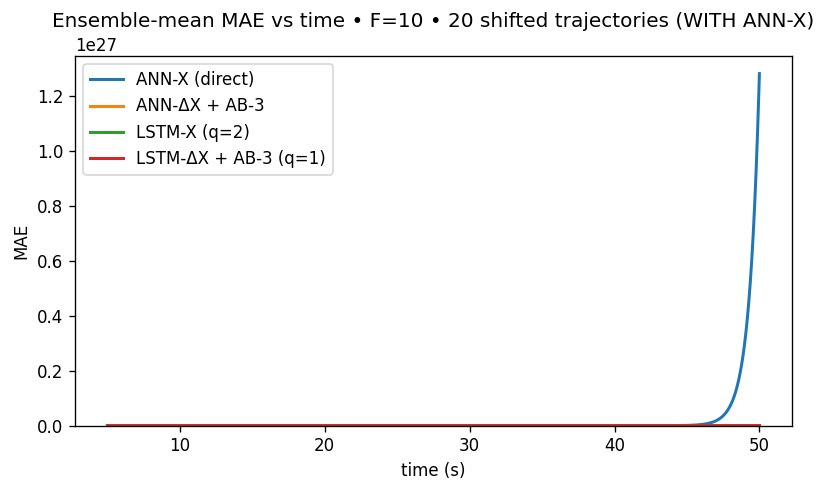

In [4]:
# =============================================================================
#  (5b) Ensemble-mean MAE(t) over first 20 shifted trajectories — WITH ANN-X
#       (still using the F=10 subset selected above; no perturbation ensemble)
# =============================================================================

# Sanity: make sure we are in the same F subset
assert 'X_F' in globals(), "Run the earlier cell that loads & filters the shifted set to F=10."

n_local = len(X_F)
n_eval  = min(20, n_local)
TEST_IDS_LOCAL = list(range(n_eval))

def mae_t(pred, truth): 
    return np.abs(pred - truth).mean(axis=1)  # (T,)

mae_annx_list, mae_annd_list, mae_lx_list, mae_ldx_list = [], [], [], []
print(f"\nComputing ensemble-mean MAE(t) over {n_eval} shifted trajectories (F={FORCE_LABEL}) … (WITH ANN-X)")

for local_id in TEST_IDS_LOCAL:
    traj  = X_F[local_id]             # (steps, 36)  — from shifted dataset (F=10 subset)
    truth = traj[i0:i_end+1]          # (T, 36)

    # Rollouts — all autoregressive; ΔX models use AB-3 in z-space
    pred_annx = rollout_ann_x (traj, mu_annx, sd_annx)                 # ANN-X (direct)
    pred_annd = rollout_ann_dx(traj, mu_annd, sd_annd)                 # ANN-ΔX (+AB3)
    pred_lx   = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)    # LSTM-X
    pred_ldx  = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)   # LSTM-ΔX (+AB3)

    mae_annx_list.append(mae_t(pred_annx, truth))
    mae_annd_list.append(mae_t(pred_annd, truth))
    mae_lx_list  .append(mae_t(pred_lx,   truth))
    mae_ldx_list .append(mae_t(pred_ldx,  truth))

# Ensemble averages over the n_eval shifted trajectories
mae_annx = np.stack(mae_annx_list).mean(0)
mae_annd = np.stack(mae_annd_list).mean(0)
mae_lx   = np.stack(mae_lx_list  ).mean(0)
mae_ldx  = np.stack(mae_ldx_list ).mean(0)

plt.figure(figsize=(6.8, 4.2), dpi=120)
plt.plot(t_axis, mae_annx, lw=1.8, label="ANN-X (direct)")
plt.plot(t_axis, mae_annd, lw=1.8, label="ANN-ΔX + AB-3")
plt.plot(t_axis, mae_lx,   lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx,  lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {n_eval} shifted trajectories (WITH ANN-X)")
plt.xlabel("time (s)")
plt.ylabel("MAE")
plt.ylim(0)
plt.legend()
plt.tight_layout()
plt.show()


Using GPU : Quadro RTX 8000 (ID 0)
F=15: using shifted representative global_idx=2 (local=0)


/state/partition1/job-64527132/ipykernel_2912764/2758874834.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
/sta

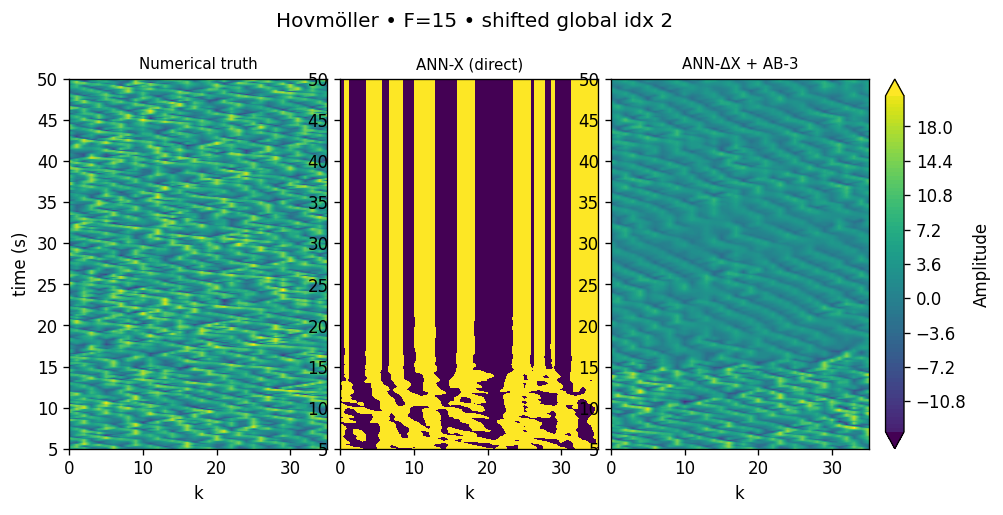

/state/partition1/job-64527132/ipykernel_2912764/2758874834.py:244: RuntimeWarning: overflow encountered in square
  def rmse_t(pred, truth): return np.sqrt(((pred - truth)**2).mean(axis=1))


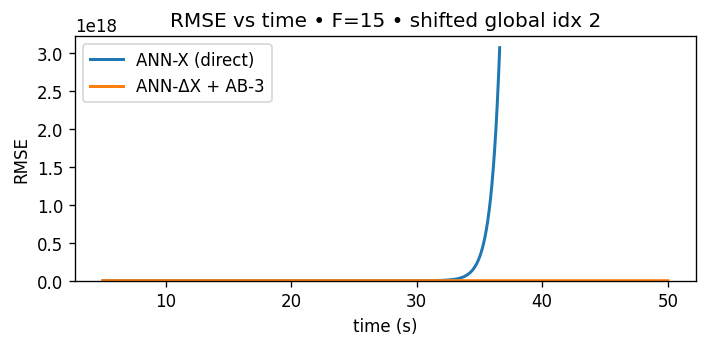

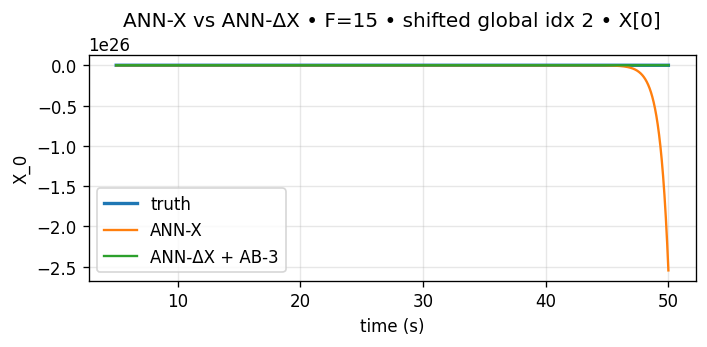

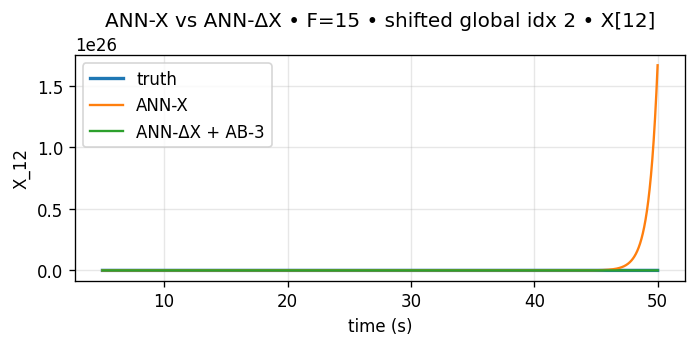

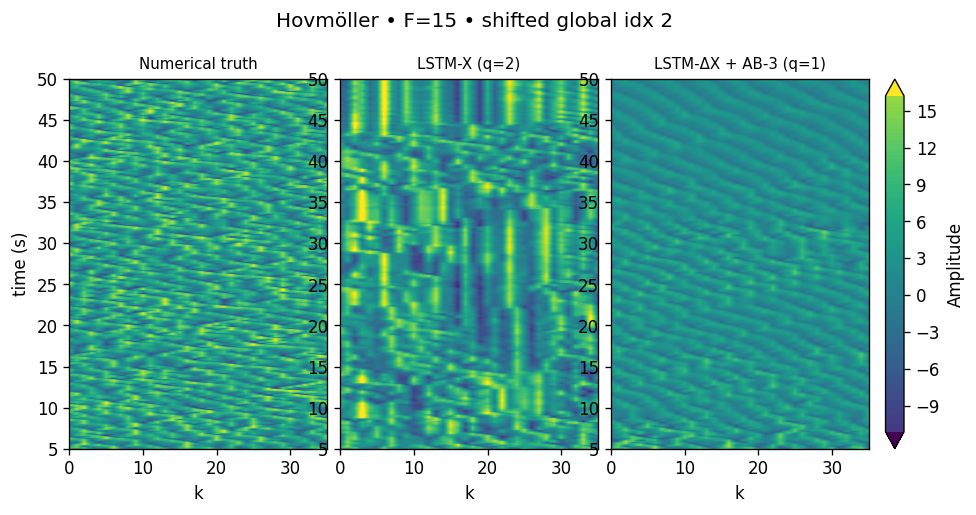

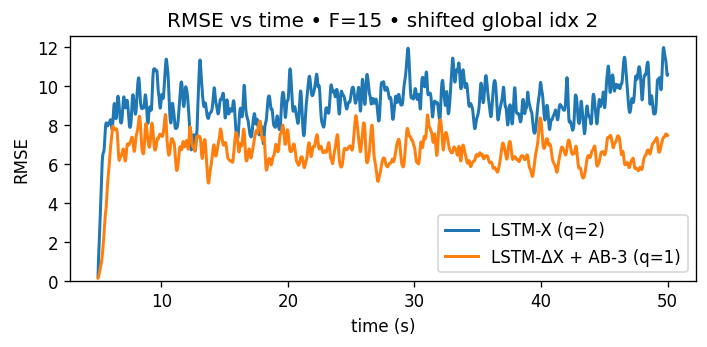

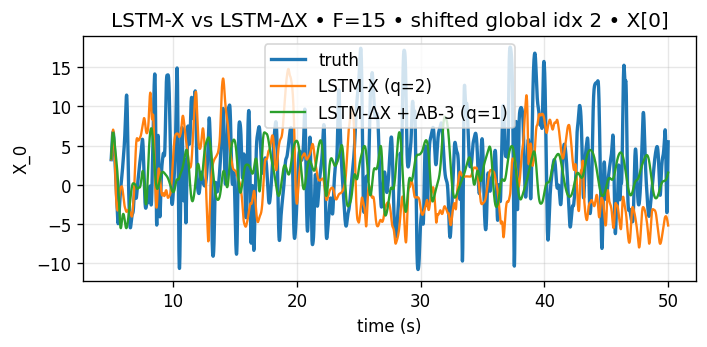

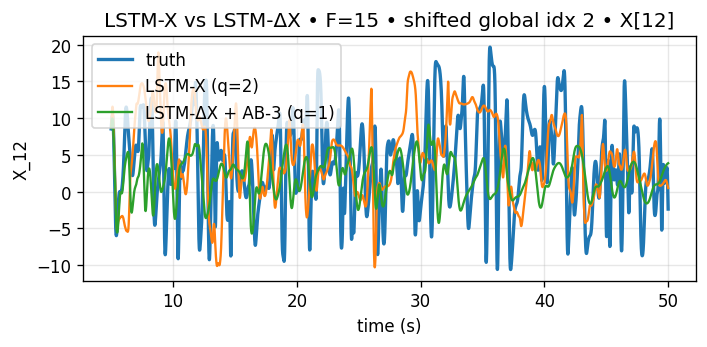

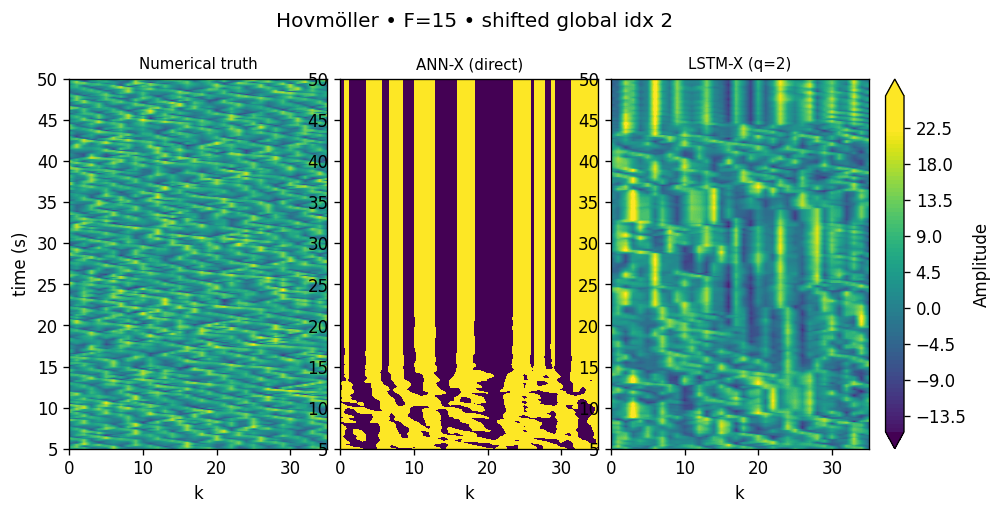

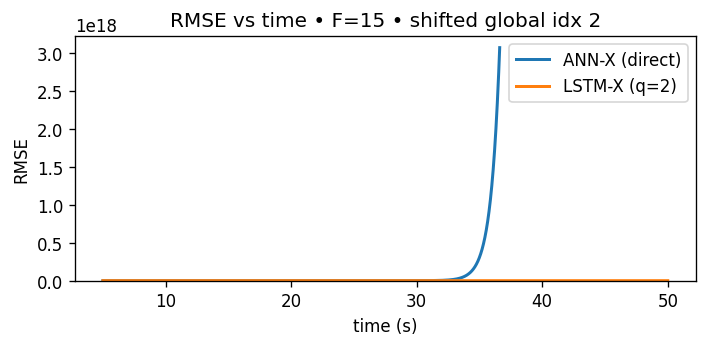

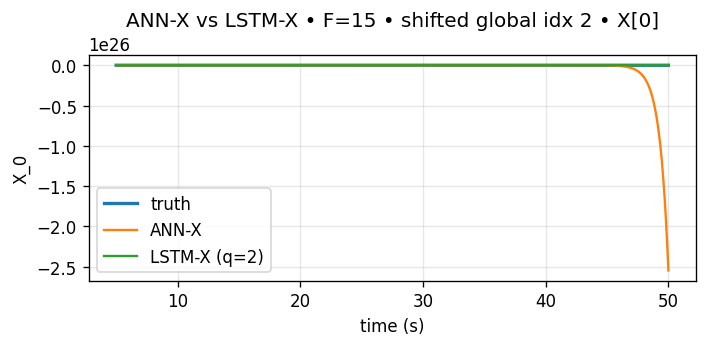

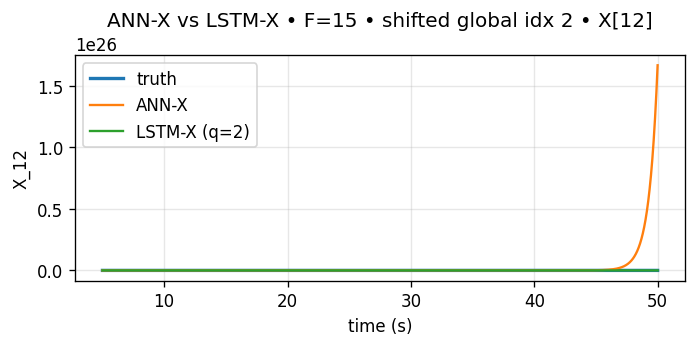

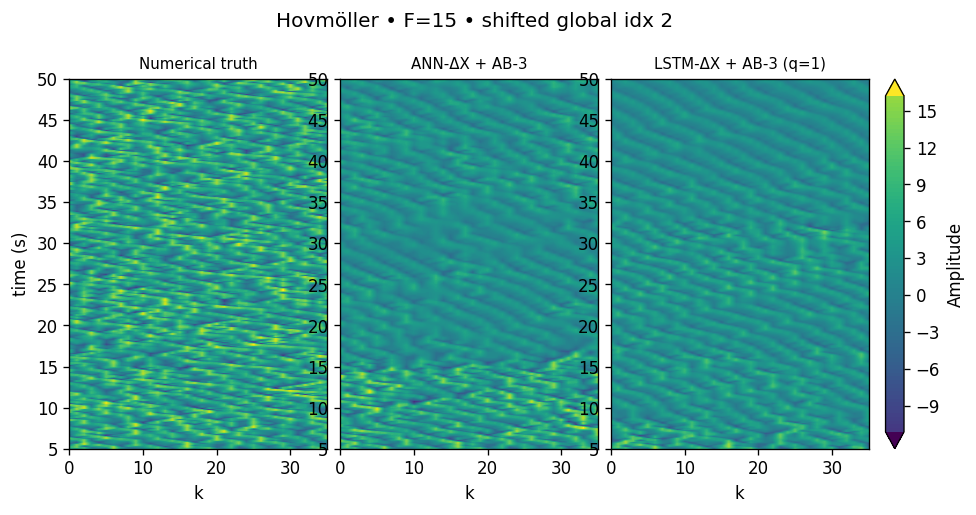

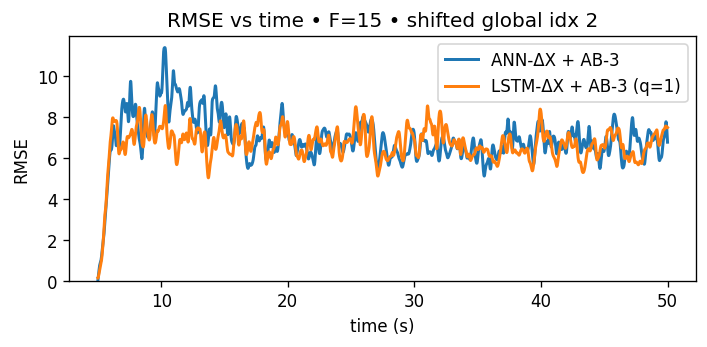

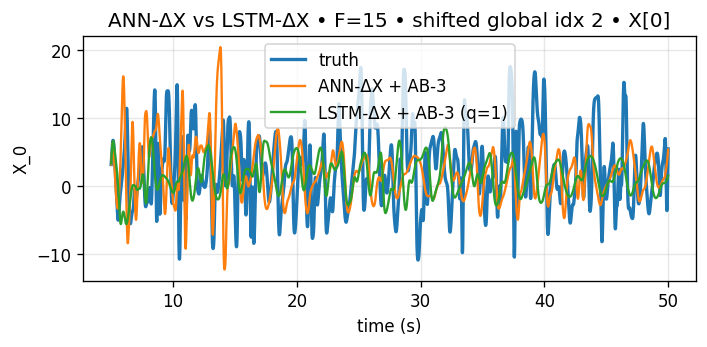

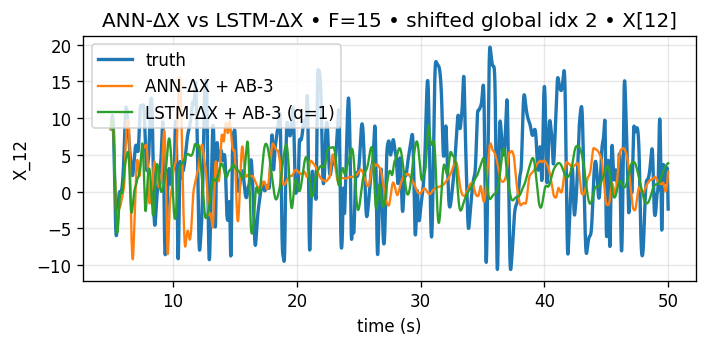


Computing ensemble-mean MAE(t) over 20 shifted trajectories (F=15) … (WITH ANN-X)


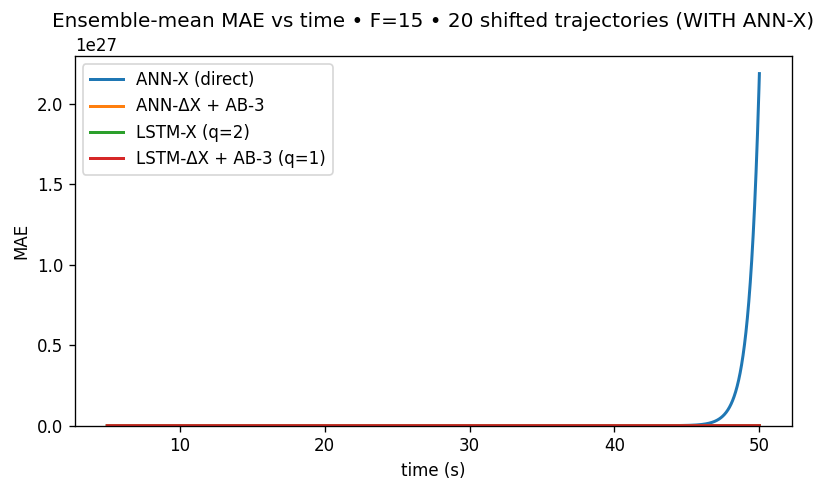


Computing ensemble-mean MAE(t) over 20 shifted trajectories (F=15) … (NO ANN-X)


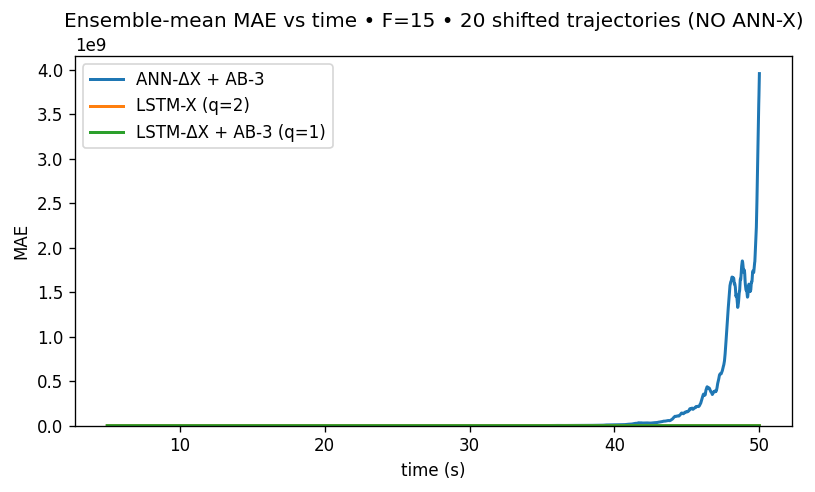


Done (F=15).


In [5]:
#!/usr/bin/env python3
# =============================================================================
#  Quantitative comparison suite (multiple-implicit; F = 15 only, merged cell)
#  -----------------------------------------------------------------------------
#  For ONE representative shifted trajectory (from F=15 subset):
#    (1) NUM vs ANN-X vs ANN-ΔX      — Hovmöller; RMSE(t); X[k] traces
#    (2) NUM vs LSTM-X vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#    (3) NUM vs ANN-X vs LSTM-X      — Hovmöller; RMSE(t); X[k] traces
#    (4) NUM vs ANN-ΔX vs LSTM-ΔX    — Hovmöller; RMSE(t); X[k] traces
#  And then on the F=15 subset only:
#    (5a) Ensemble-mean MAE(t) over first 20 shifted trajectories — WITH ANN-X
#    (5b) Ensemble-mean MAE(t) over first 20 shifted trajectories — NO ANN-X
#
#  Notes:
#    • Uses a single mixed-F shifted file with labels; filters to F=15.
#    • ΔX models (ANN-ΔX & LSTM-ΔX) are integrated via Euler→AB2→AB3 **in z-space**.
#    • Direct X models (ANN-X & LSTM-X) predict X̂(t+Δt) (no AB).
#    • q (lookback) is read from LSTM checkpoint metadata or filename “_q{q}.pt”.
#    • EASY KNOBS below: TRAJ_LOCAL_IDX, DT, T0, T_END, K_TO_PLOT.
# =============================================================================

import os, re, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ────────────────────────── EASY KNOBS ─────────────────────────────────────
FORCE_LABEL     = 15                 # Which forcing to analyse (fixed in this cell)
TRAJ_LOCAL_IDX  = 0                  # Which trajectory within the F=15 subset to showcase (0-based)
DT, T0, T_END   = 0.005, 5.0, 50.0   # Time step, start time, end time
K_TO_PLOT       = (0, 12)            # Two components to show in line plots

# File names (adjust if your names differ)
TRAIN_FILE_MIXED  = "force_5_10_15_data.npz"            # μ/σ fallback (mixed-F training)
SHIFTED_FILE      = "shifted_force5_10_15_data.npz"     # mixed-F shifted set with labels

# Best-q checkpoints you provided for multiple-implicit
CKPT_ANN_X        = "standard_early_stopping_F5_10_15_annX.pt"                  # ANN-X (direct)
CKPT_ANN_DX       = "standard_early_stopping_F5_10_15_ann.pt"                   # ANN-ΔX (delta)
CKPT_LSTM_X       = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"       # LSTM-X (q=2)
CKPT_LSTM_DX      = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"    # LSTM-ΔX (q=1)

# ────────────────────────── DEVICE ─────────────────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ────────────────────────── TIME AXES ──────────────────────────────────────
steps_per_s = int(round(1/DT))
i0, i_end   = int(T0*steps_per_s), int(T_END*steps_per_s)  # inclusive span
t_axis      = np.arange(i0, i_end+1, dtype=np.float32) * DT
assert i_end > i0, "T_END must be > T0."

# ────────────────────────── HELPERS ────────────────────────────────────────
def parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def find_state_dict(obj):
    """Locate a state_dict in a checkpoint object."""
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, (torch.Tensor, np.ndarray)) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = find_state_dict(v)
                if sd is not None: return sd
    return None

# AB-3 in z-space (Euler→AB2→AB3)
def ab3(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:  return dx1
    if dx_prev2 is None:  return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

# ────────────────────────── MODELS ─────────────────────────────────────────
def make_mlp(sizes=(36,128,128,64,36), act="relu"):
    acts = dict(tanh=nn.Tanh, relu=nn.ReLU, gelu=nn.GELU)
    layers = []
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes)-2:
            layers.append(acts[act]())
    return nn.Sequential(*layers)

class LSTM_X(nn.Module):
    """One-layer LSTM that outputs next-state X̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):              # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])      # (B,N)

class LSTM_dX(nn.Module):
    """One-layer LSTM that outputs ΔX̂ (normalised)."""
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):              # w: (B,q,N) in z-space
        y,_ = self.lstm(w)
        return self.head(y[:,-1])      # (B,N) ΔX̂

# ────────────────────────── LOAD DATASETS ─────────────────────────────────
# μ/σ fallback from mixed training set
train_mixed = np.load(TRAIN_FILE_MIXED)["X"].astype(np.float32).reshape(-1, 36)
MU_FALL = train_mixed.mean(0).astype(np.float32)
SD_FALL = (train_mixed.std(0) + 1e-8).astype(np.float32)

# Load mixed-F shifted file and filter to F=15
shifted = np.load(SHIFTED_FILE)
X_shift_all = shifted["X"].astype(np.float32)        # (traj, step, 36)
F_shift_all = shifted["F"].astype(np.int32)          # (traj,)
_, N_STEPS, N = X_shift_all.shape
assert i_end + 1 <= N_STEPS, "Requested [T0,T_END] exceeds shifted data length."

idx_f = np.where(F_shift_all == FORCE_LABEL)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={FORCE_LABEL}"
X_F = X_shift_all[idx_f]                              # (n_f, step, 36)
assert 0 <= TRAJ_LOCAL_IDX < len(X_F), f"TRAJ_LOCAL_IDX out of range (0..{len(X_F)-1})"
global_id = int(idx_f[TRAJ_LOCAL_IDX])

print(f"F={FORCE_LABEL}: using shifted representative global_idx={global_id} (local={TRAJ_LOCAL_IDX})")

# Truth slice for the representative trajectory
truth_fixed = X_F[TRAJ_LOCAL_IDX, i0:i_end+1]        # (T,N)

# ────────────────────────── LOAD CHECKPOINTS ───────────────────────────────
# ANN-X
annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
ann_x = make_mlp().to(DEVICE).eval()
ann_x.load_state_dict(annx_ckpt.get("net", annx_ckpt))
mu_annx = annx_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annx = annx_ckpt.get("std",  SD_FALL).astype(np.float32)

# ANN-ΔX
annd_ckpt = torch.load(CKPT_ANN_DX, map_location="cpu")
ann_dx = make_mlp().to(DEVICE).eval()
ann_dx.load_state_dict(annd_ckpt.get("net", annd_ckpt))
mu_annd = annd_ckpt.get("mean", MU_FALL).astype(np.float32)
sd_annd = annd_ckpt.get("std",  SD_FALL).astype(np.float32)

# LSTM-X
lstm_x_raw = torch.load(CKPT_LSTM_X, map_location="cpu")
sd_xdict   = find_state_dict(lstm_x_raw)
if sd_xdict is None:
    raise RuntimeError(f"Could not find state-dict in LSTM-X checkpoint: {CKPT_LSTM_X}")
hidden_x   = int(lstm_x_raw.get("hidden_size", 70)) if isinstance(lstm_x_raw, dict) else 70
q_x_meta   = int(lstm_x_raw.get("lookback")) if isinstance(lstm_x_raw, dict) and ("lookback" in lstm_x_raw) else None
q_x        = q_x_meta or parse_q_from_filename(CKPT_LSTM_X)
if q_x is None:
    raise ValueError("Cannot determine q for LSTM-X. Rename file with _q{q}.pt or store 'lookback' in ckpt.")
assert i0 + 1 >= q_x, f"T0 is too early for q={q_x}: need at least {(q_x-1)*DT:.3f}s of history."
lstm_x = LSTM_X(hidden_x, n=N).to(DEVICE).eval()
lstm_x.load_state_dict(sd_xdict)
mu_lx = (lstm_x_raw.get("mean", MU_FALL) if isinstance(lstm_x_raw, dict) else MU_FALL).astype(np.float32)
sd_lx = (lstm_x_raw.get("std",  SD_FALL) if isinstance(lstm_x_raw, dict) else SD_FALL).astype(np.float32)

# LSTM-ΔX
lstm_dx_raw = torch.load(CKPT_LSTM_DX, map_location="cpu")
sd_dxdict   = find_state_dict(lstm_dx_raw)
if sd_dxdict is None:
    raise RuntimeError(f"Could not find state-dict in LSTM-ΔX checkpoint: {CKPT_LSTM_DX}")
hidden_dx   = int(lstm_dx_raw.get("hidden_size", 70)) if isinstance(lstm_dx_raw, dict) else 70
q_dx_meta   = int(lstm_dx_raw.get("lookback")) if isinstance(lstm_dx_raw, dict) and ("lookback" in lstm_dx_raw) else None
q_dx        = q_dx_meta or parse_q_from_filename(CKPT_LSTM_DX)
if q_dx is None:
    raise ValueError("Cannot determine q for LSTM-ΔX. Rename file with _q{q}.pt or store 'lookback' in ckpt.")
assert i0 + 1 >= q_dx, f"T0 is too early for q={q_dx}: need at least {(q_dx-1)*DT:.3f}s of history."
lstm_dx = LSTM_dX(hidden_dx, n=N).to(DEVICE).eval()
lstm_dx.load_state_dict(sd_dxdict)
mu_ldx = (lstm_dx_raw.get("mean", MU_FALL) if isinstance(lstm_dx_raw, dict) else MU_FALL).astype(np.float32)
sd_ldx = (lstm_dx_raw.get("std",  SD_FALL) if isinstance(lstm_dx_raw, dict) else SD_FALL).astype(np.float32)

# ────────────────────────── ROLLOUT HELPERS ───────────────────────────────
@torch.no_grad()
def rollout_ann_x(traj_phys, mu, sdv):
    """ANN-X: X̂(t+Δt) in z-space, autoregressive, no AB."""
    prev_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)
    prev   = torch.from_numpy(prev_z).to(DEVICE)
    mu_t   = torch.from_numpy(mu).to(DEVICE)
    sd_t   = torch.from_numpy(sdv).to(DEVICE)
    preds=[]
    for _ in range(i0, i_end+1):
        nxt_z = ann_x(prev.unsqueeze(0))                        # (1,N)
        preds.append((nxt_z * sd_t + mu_t).squeeze(0).cpu().numpy())
        prev = nxt_z.squeeze(0)
    return np.stack(preds)

@torch.no_grad()
def rollout_ann_dx(traj_phys, mu, sdv):
    """ANN-ΔX: AB3 in z-space on ΔX̂."""
    x_z = ((traj_phys[i0-1] - mu) / sdv).astype(np.float32)
    x   = torch.from_numpy(x_z).to(DEVICE)
    mu_t = torch.from_numpy(mu).to(DEVICE)
    sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds=[]; dx_prev1=dx_prev2=None
    for _ in range(i0, i_end+1):
        dx1  = ann_dx(x.unsqueeze(0))                           # (1,N)
        step = ab3(dx1, dx_prev1, dx_prev2)
        x    = x + step.squeeze(0)
        preds.append((x * sd_t + mu_t).cpu().numpy())
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)

@torch.no_grad()
def rollout_lstm_x(traj_phys, net, q, mu, sdv):
    """LSTM-X: true history window [t0-q+1 … t0] in z; predicts X̂(t0+Δt); slide."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)  # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)              # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE); sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds=[]
    for _ in range(i0, i_end+1):
        y = net(win)                                                 # (1,N)
        preds.append((y * sd_t + mu_t).squeeze(0).cpu().numpy())
        win = torch.cat([win[:,1:,:], y.unsqueeze(1)], dim=1)
    return np.stack(preds)

@torch.no_grad()
def rollout_lstm_dx(traj_phys, net, q, mu, sdv):
    """LSTM-ΔX: true history [t0-q+1 … t0] in z; ΔX̂ → AB3 in z; slide."""
    win = ((traj_phys[i0-q+1:i0+1] - mu) / sdv).astype(np.float32)   # (q,N)
    win = torch.from_numpy(win).unsqueeze(0).to(DEVICE)               # (1,q,N)
    mu_t = torch.from_numpy(mu).to(DEVICE); sd_t = torch.from_numpy(sdv).to(DEVICE)
    preds=[]; dx_prev1=dx_prev2=None
    for _ in range(i0, i_end+1):
        dx1   = net(win)                                             # (1,N)
        step  = ab3(dx1, dx_prev1, dx_prev2)
        new_z = win[:, -1, :] + step
        preds.append((new_z * sd_t + mu_t).squeeze(0).cpu().numpy())
        win = torch.cat([win[:,1:,:], new_z.unsqueeze(1)], dim=1)
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)

def rmse_t(pred, truth): return np.sqrt(((pred - truth)**2).mean(axis=1))
def mae_t (pred, truth): return np.abs (pred - truth).mean(axis=1)

# ────────────────────────── PLOTTING HELPERS ─────────────────────────────
def hovmoller(t_axis, truth, pred1, pred2, lab1, lab2, suptitle):
    vmin, vmax = truth.min(), truth.max()
    k_axis = np.arange(truth.shape[1])
    fig, axs = plt.subplots(1, 3, figsize=(9, 4), dpi=120, gridspec_kw={"wspace":0.05})
    for ax, mat, ttl in zip(axs, (truth, pred1, pred2), ("Numerical truth", lab1, lab2)):
        cf = ax.contourf(k_axis, t_axis, mat, 100, cmap="viridis",
                         vmin=vmin, vmax=vmax, extend="both")
        ax.set_xlabel("k"); ax.set_ylim(t_axis[0], t_axis[-1])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(ttl, fontsize=9)
    axs[0].set_ylabel("time (s)")
    fig.colorbar(cf, ax=axs, fraction=0.025, pad=0.02, label="Amplitude")
    fig.suptitle(suptitle, y=1.02)
    plt.tight_layout(); plt.show()

def plot_rmse(t_axis, rmse1, rmse2, lab1, lab2, title):
    plt.figure(figsize=(6,3), dpi=120)
    plt.plot(t_axis, rmse1, lw=1.8, label=lab1)
    plt.plot(t_axis, rmse2, lw=1.8, label=lab2)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE"); plt.ylim(0); plt.legend()
    plt.tight_layout(); plt.show()

def plot_traces(t_axis, truth, pred1, pred2, k_pair, lab1, lab2, title):
    for k in k_pair:
        plt.figure(figsize=(6,3), dpi=120)
        plt.plot(t_axis, truth[:,k], lw=2.0, label="truth")
        plt.plot(t_axis, pred1[:,k], lw=1.4, label=lab1)
        plt.plot(t_axis, pred2[:,k], lw=1.4, label=lab2)
        plt.title(f"{title} • X[{k}]")
        plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ────────────────────────── REPRESENTATIVE TRAJECTORY PANELS ──────────────
ann_x_pred   = rollout_ann_x (X_F[TRAJ_LOCAL_IDX], mu_annx, sd_annx)
ann_dx_pred  = rollout_ann_dx(X_F[TRAJ_LOCAL_IDX], mu_annd, sd_annd)
lstm_x_pred  = rollout_lstm_x (X_F[TRAJ_LOCAL_IDX], lstm_x,  q_x,  mu_lx,  sd_lx)
lstm_dx_pred = rollout_lstm_dx(X_F[TRAJ_LOCAL_IDX], lstm_dx, q_dx, mu_ldx, sd_ldx)

for name, arr in [("ann_x_pred", ann_x_pred), ("ann_dx_pred", ann_dx_pred),
                  ("lstm_x_pred", lstm_x_pred), ("lstm_dx_pred", lstm_dx_pred)]:
    assert arr.shape == truth_fixed.shape, f"{name} shape {arr.shape}, expected {truth_fixed.shape}"

# (1) ANN-X vs ANN-ΔX
hovmoller(t_axis, truth_fixed, ann_x_pred, ann_dx_pred,
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(ann_dx_pred, truth_fixed),
          "ANN-X (direct)", "ANN-ΔX + AB-3",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, ann_x_pred, ann_dx_pred, K_TO_PLOT,
            "ANN-X", "ANN-ΔX + AB-3",
            f"ANN-X vs ANN-ΔX • F={FORCE_LABEL} • shifted global idx {global_id}")

# (2) LSTM-X vs LSTM-ΔX
hovmoller(t_axis, truth_fixed, lstm_x_pred, lstm_dx_pred,
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(lstm_x_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, lstm_x_pred, lstm_dx_pred, K_TO_PLOT,
            f"LSTM-X (q={q_x})", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"LSTM-X vs LSTM-ΔX • F={FORCE_LABEL} • shifted global idx {global_id}")

# (3) ANN-X vs LSTM-X
hovmoller(t_axis, truth_fixed, ann_x_pred, lstm_x_pred,
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(ann_x_pred, truth_fixed), rmse_t(lstm_x_pred, truth_fixed),
          "ANN-X (direct)", f"LSTM-X (q={q_x})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, ann_x_pred, lstm_x_pred, K_TO_PLOT,
            "ANN-X", f"LSTM-X (q={q_x})",
            f"ANN-X vs LSTM-X • F={FORCE_LABEL} • shifted global idx {global_id}")

# (4) ANN-ΔX vs LSTM-ΔX
hovmoller(t_axis, truth_fixed, ann_dx_pred, lstm_dx_pred,
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"Hovmöller • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_rmse(t_axis, rmse_t(ann_dx_pred, truth_fixed), rmse_t(lstm_dx_pred, truth_fixed),
          "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
          f"RMSE vs time • F={FORCE_LABEL} • shifted global idx {global_id}")
plot_traces(t_axis, truth_fixed, ann_dx_pred, lstm_dx_pred, K_TO_PLOT,
            "ANN-ΔX + AB-3", f"LSTM-ΔX + AB-3 (q={q_dx})",
            f"ANN-ΔX vs LSTM-ΔX • F={FORCE_LABEL} • shifted global idx {global_id}")

# ────────────────────────── (5a) ENSEMBLE-MEAN MAE(t) — WITH ANN-X ────────
n_local = len(X_F)
n_eval  = min(20, n_local)
TEST_IDS_LOCAL = list(range(n_eval))

mae_annx_list, mae_annd_list, mae_lx_list, mae_ldx_list = [], [], [], []
print(f"\nComputing ensemble-mean MAE(t) over {n_eval} shifted trajectories (F={FORCE_LABEL}) … (WITH ANN-X)")

for local_id in TEST_IDS_LOCAL:
    traj  = X_F[local_id]
    truth = traj[i0:i_end+1]

    pred_annx = rollout_ann_x (traj, mu_annx, sd_annx)                # ANN-X (direct)
    pred_annd = rollout_ann_dx(traj, mu_annd, sd_annd)                # ANN-ΔX (+AB3)
    pred_lx   = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)   # LSTM-X
    pred_ldx  = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)  # LSTM-ΔX (+AB3)

    mae_annx_list.append(mae_t(pred_annx, truth))
    mae_annd_list.append(mae_t(pred_annd, truth))
    mae_lx_list  .append(mae_t(pred_lx,   truth))
    mae_ldx_list .append(mae_t(pred_ldx,  truth))

mae_annx = np.stack(mae_annx_list).mean(0)
mae_annd = np.stack(mae_annd_list).mean(0)
mae_lx   = np.stack(mae_lx_list  ).mean(0)
mae_ldx  = np.stack(mae_ldx_list ).mean(0)

plt.figure(figsize=(6.8,4.2), dpi=120)
plt.plot(t_axis, mae_annx, lw=1.8, label="ANN-X (direct)")
plt.plot(t_axis, mae_annd, lw=1.8, label="ANN-ΔX + AB-3")
plt.plot(t_axis, mae_lx,   lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx,  lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {n_eval} shifted trajectories (WITH ANN-X)")
plt.xlabel("time (s)"); plt.ylabel("MAE"); plt.ylim(0); plt.legend()
plt.tight_layout(); plt.show()

# ────────────────────────── (5b) ENSEMBLE-MEAN MAE(t) — NO ANN-X ──────────
mae_annd_list, mae_lx_list, mae_ldx_list = [], [], []
print(f"\nComputing ensemble-mean MAE(t) over {n_eval} shifted trajectories (F={FORCE_LABEL}) … (NO ANN-X)")

for local_id in TEST_IDS_LOCAL:
    traj  = X_F[local_id]
    truth = traj[i0:i_end+1]

    pred_annd = rollout_ann_dx(traj, mu_annd, sd_annd)                 # ANN-ΔX (+AB3)
    pred_lx   = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)    # LSTM-X
    pred_ldx  = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)   # LSTM-ΔX (+AB3)

    mae_annd_list.append(mae_t(pred_annd, truth))
    mae_lx_list  .append(mae_t(pred_lx,   truth))
    mae_ldx_list .append(mae_t(pred_ldx,  truth))

mae_annd = np.stack(mae_annd_list).mean(0)
mae_lx   = np.stack(mae_lx_list  ).mean(0)
mae_ldx  = np.stack(mae_ldx_list ).mean(0)

plt.figure(figsize=(6.8,4.2), dpi=120)
plt.plot(t_axis, mae_annd, lw=1.8, label="ANN-ΔX + AB-3")
plt.plot(t_axis, mae_lx,   lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx,  lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {n_eval} shifted trajectories (NO ANN-X)")
plt.xlabel("time (s)"); plt.ylabel("MAE"); plt.ylim(0); plt.legend()
plt.tight_layout(); plt.show()

print("\nDone (F=15).")



Computing ensemble-mean MAE(t) over 20 shifted trajectories (F=15) … (LSTM ONLY)


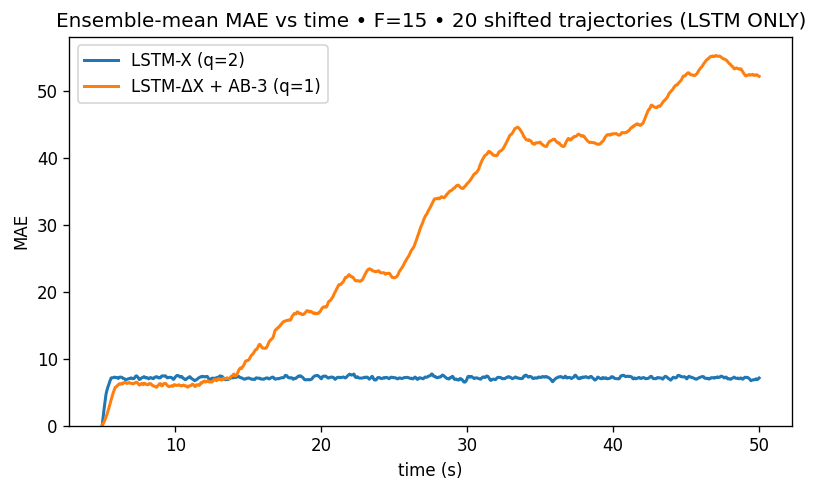

In [6]:
# ────────────────────────── (5c) ENSEMBLE-MEAN MAE(t) — LSTM ONLY ─────────
# Uses ONLY LSTM-X and LSTM-ΔX (no ANN models) on the F={FORCE_LABEL} subset.

n_local = len(X_F)
n_eval  = min(20, n_local)
TEST_IDS_LOCAL = list(range(n_eval))

mae_lx_list, mae_ldx_list = [], []
print(f"\nComputing ensemble-mean MAE(t) over {n_eval} shifted trajectories (F={FORCE_LABEL}) … (LSTM ONLY)")

for local_id in TEST_IDS_LOCAL:
    traj  = X_F[local_id]
    truth = traj[i0:i_end+1]

    # LSTM-X (direct next-state; no AB)
    pred_lx  = rollout_lstm_x (traj, lstm_x,  q_x,  mu_lx,  sd_lx)
    # LSTM-ΔX (+AB3 in z-space)
    pred_ldx = rollout_lstm_dx(traj, lstm_dx, q_dx, mu_ldx, sd_ldx)

    mae_lx_list .append(mae_t(pred_lx,  truth))
    mae_ldx_list.append(mae_t(pred_ldx, truth))

mae_lx  = np.stack(mae_lx_list ).mean(0)
mae_ldx = np.stack(mae_ldx_list).mean(0)

plt.figure(figsize=(6.8,4.2), dpi=120)
plt.plot(t_axis, mae_lx,  lw=1.8, label=f"LSTM-X (q={q_x})")
plt.plot(t_axis, mae_ldx, lw=1.8, label=f"LSTM-ΔX + AB-3 (q={q_dx})")
plt.title(f"Ensemble-mean MAE vs time • F={FORCE_LABEL} • {n_eval} shifted trajectories (LSTM ONLY)")
plt.xlabel("time (s)"); plt.ylabel("MAE"); plt.ylim(0); plt.legend()
plt.tight_layout(); plt.show()
